A13895199 Hongtao Zhang: coding, statistics, and version control

A12035504 Francisco Ochoa: visualization and coding

A12314205 Oscar Bao: coding and version control

A15358078 Gustav Santo-Tomas: statistics, visualization, and coding

A12156811 Austin German: markdown, proofreading, organization of group meetings

# Introduction

In recent years, homicide rates have been increasing in large urban areas such as Chicago and Baltimore
(https://www.ncjrs.gov/pdffiles1/nij/251067.pdf). Specifically, cities with a population higher than 250,000
saw a 15.2% increase in homicides over 2014-2015 (https://ucr.fbi.gov/ucr-publications). Gun violence is a 
significant contributor to homicide rates in the United States: in 2011, 68% of murders involved a firearm 
(https://www.nij.gov/topics/crime/gun-violence). Gun violence is particularly concerning as it disproportionately 
affects young people aged 15-17, who are more likley to die from a firearms-related incident than any other age 
group (https://www.nij.gov/topics/crime/gun-violence/Pages/affected.aspx). Some of the controversy around gun 
ownership stems from restrictions on the purchase of firearms. In 1993,  Brady Handgun Violence Prevention Act
was passed, which mandated the establishment of the National Instant Criminal Background Check System by the FBI
with the purpose of prevent the sale of firearms to individuals with dangerous backgrounds (https://www.fbi.gov/services/cjis/nics).
Before finalizing a firearm sale, cashiers can check whether a consumer has a criminal record by referencing the NICS.
Unfortunately, there are large gaps in the FBI’s background check data as a significant percentage of felonyconvictictions recorded by law enforcement agencies is not reported to the FBI. 
(http://www.chicagotribune.com/news/nationworld/ct-fbi-gun-background-check-system-missing-records-20171110-story.html).
This lack of data might allow individuals to purchase firearms who would otherwise be ineligible to do so, potentially
inflating the number of firearms-related deaths in the United
States and calling into question the reliability of the NICS. In an attempt to remedy this situation,
here we present an analysis of the relationship between state background checks and the rates of gun-related crime.
 


# Hypothesis

States that perform background checks on people attempting to purchase guns will have lower violent crime rates than
the states which do not perform background checks. It is however also possible that the opposite is true: data suggesting
that certain states perform more frequent background checks may simply reflect more frequent sales of firearms in general,
which in and of itself could be an indicator that gun-related violent crimes are positively correlated with firearm sales.


In [1]:
###====Imports====###

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline
import matplotlib.image as mpimg
from bs4 import BeautifulSoup
from sklearn import linear_model
import statsmodels.api as sm
from patsy import dmatrices
import statsmodels.formula.api as smf
from scipy.stats import pearsonr


sns.set()

Populating the interactive namespace from numpy and matplotlib


F:\anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Data Cleaning and Preprocessing

data loading and preprocessing
We used four datasets in our analysis: First we obtained data on state firearm background checks from Rand State Statistics
    (http://www.randstatestats.org/us/stats/firearm-background-checks.html). This data set has 1064 entries and lists number of
    background checks performed via NICS per month per year for each state. It includes background check data categorized by
    state, cateogry, year (1998-2016), month, and total number. From the same source, we got data on th enumber of homicides by
    state and weapon used (http://www.randstatestats.org/us/stats/homicides-by-state-and-weapon-used.html). This data set has 486
    entries and lists number of homicides recorded for each state per year (1996-2016) as well as the weapons used. From Rand
    State Statistics we also download historical population estimates for each state between the years 1996 and 2016.
    (http://www.randstatestats.org/us/stats/homicides-by-state-and-weapon-used.html) That data set has 486 entries. 
    Finally, we consulted the FBI’s Uniform Crime Reporting database to obtain crime rates, sorted by state, population, 
    and crime total for the years 1960 to 2014. There were 8100 entries in that data set 
    (https://www.ucrdatatool.gov/Search/Crime/State/RunCrimeStatebyState.cfm).

Data cleaning
Clearly, these data sets are not uniform in terms of the years they cover. All data sets were cleaned such that only the years 
2000-2014 are included, as these are the years which for which all datasets provide information. It was also necessary to 
standardize the formatting of the datasets, such that “State” could be assigned to the rows and “Year” to the columns. 
Additionally, some of these data sets include locations other than states such as Washington D.C. or other U.S territories. 
These rows were dropped as we are limiting our analysis to the 50 states. Missing data points were dropped and interpolated
using a linear regression function, described in detail below.

We cleaned the UCR data first. Since these data were contained in an html file, we used an html parser from BeautifulSoup
to open the data. The desired data were located via the built-in ‘find’ method, and then converted from an html table object 
to a list of data frames with the pandas’ read_html method. The original data included years outside the scope of our analysis,
so we dropped those columns.



In [2]:
#Linear Regression Function
#predict y from x
#param: colx, coly (Series object)
#return coeficent, intercept
#for y = kx + b, it returns k,b
def LR(colx, coly, plot = False):
    df = pd.DataFrame({'x':colx,
                       'y':coly})
    df.apply(pd.to_numeric)
    x = np.reshape(df.x.values, [len(df.x), 1])
    y = np.reshape(df.y.values, [len(df.y), 1])
    reg = linear_model.LinearRegression()
    reg.fit(x, y)
    if plot == True :
        print(df)
        plt.scatter(df['x'], df['y'], label = 'Data');
        xs = np.arange(float(df['x'].min()), float(df['x'].max()))
        ys = reg.coef_[0][0] * xs + reg.intercept_[0]
        plt.plot(xs, ys, '--k', linewidth=4, label='Model')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.show()
        
    return reg.coef_[0][0], reg.intercept_[0]

#default pandas extraction from csv pulls columns into indices.
#re-extract indices back into columns via temp index column
def extractIndex(df):
    df['index'] = df.index
    df_first_row = df.index[0]
    for i in range(len(df_first_row)):
        df[df_first_row[i]] = df['index'].apply(lambda idx : idx[i])
    return df.drop(['index'], axis=1)

#reset indices to numerical range
def rekeyIndex(df):
    df.index = range(df.shape[0])
    return df

#Cast all entries of a dataframe to 'int' type
#Since all our dataframes entries are numbers entered 
#as strings, especially for large number with commas 
#This function drops those commas 
def df_to_int(df): 
    def to_apply_int(x):
        if type(x) == str : 
            return int(x.replace(',', ''))
        if type(x) == float :
            if np.isnan(x) != True :
                return int(x)
        return x
    return df.apply(lambda col : col.apply(to_apply_int), axis = 1)

#Cast all entries of a dataframe to 'float' type
#float version of the above func
def df_to_float(df): 
    def to_apply_float(x):
        if type(x) == str : 
            return float(x.replace(',', ''))
        return x
    return df.apply(lambda col : col.apply(to_apply_float), axis = 1)

In [3]:
#Set dataframe to display maximum space that it allows to print
pd.options.display.max_columns = 999

We dealt with the firearm background check data next. After loading it into a dataframe with pandas.read_csv, we renamed the 
columns to labels more convenient for our purposes. We then separated the background check data into those that were per 1k
people and those that were per person. This made the ‘category’ row irrelevant, so we dropped it. Once again we cropped out 
years beyond the scope of our analysis (2000-2014). 



In [4]:
#Name the dataframe to 'df' temporarily for convenience
#Open the html file by BeautifulSoup with an 'html parser'
soup = BeautifulSoup(open("data/Uniform Crime Reporting Statistics.html"), 'html.parser')
#Use BeautifulSoup's built in method 'find' to get the table with desired data 
table = soup.find('table', {'title':'Data table:crime, state level, one variable of data'})
#Convert the html table object to a list of dataframes by pandas' read_html method
dfs = pd.read_html(str(table))
#All data is stored in dfs[0]
df = dfs[0]

#drop irrelavant parts, formatting the dataframe
df = df.drop(df.index[1])
df = df.drop(df.index[1:41])
df = df.drop(df.columns[9], axis = 1)
df.columns = df.iloc[0]
df.drop(df.index[0],inplace = True)

#cast the year column index to int
df['Year'] = df['Year'].apply(lambda y : int(y))

df.set_index('Year', inplace = True)
df = df.T

df.columns.name = 'Year'
df.index.name = 'State'
df = df_to_float(df)
crimeRateDF = df
crimeRateDF


Year            2000  2001  2002  2003  2004  2005  2006  2007  2008  2009  \
State                                                                        
Alabama          7.4   8.5   6.8   6.6   5.6   8.2   8.3   8.9   7.5   6.8   
Alaska           4.3   6.2   5.1   6.0   5.6   4.8   5.4   6.3   3.9   3.1   
Arizona          7.0   7.5   7.1   7.9   7.2   7.5   8.6   8.6   7.1   5.8   
Arkansas         6.3   5.5   5.2   6.6   6.4   6.8   7.3   7.0   5.8   6.2   
California       6.1   6.4   6.8   6.8   6.7   6.9   6.8   6.2   5.8   5.3   
Colorado         3.1   3.6   4.0   4.1   4.4   3.7   3.6   3.2   3.3   3.2   
Connecticut      2.9   3.1   2.4   3.2   2.9   3.0   3.9   3.2   3.8   3.0   
Delaware         3.2   2.9   3.2   2.6   3.4   4.4   4.9   4.5   6.5   4.6   
Florida          5.6   5.3   5.5   5.4   5.4   5.0   6.2   6.6   6.4   5.5   
Georgia          8.0   7.1   7.1   7.6   6.9   6.2   6.5   7.5   6.6   5.8   
Hawaii           2.9   2.6   1.9   1.8   2.6   1.9   1.6   1.9   2.0   1.8   
Idaho            1.2   2.3   2.7   1.9   2.2   2.4   2.4   3.3   1.5   1.6   
Illinois         7.2   7.8   7.6   7.1   6.1   6.0   6.1   5.9   6.1   6.0   
Indiana          5.8   6.7   5.9   5.5   5.1   5.7   5.7   5.5   5.0   4.9   
Iowa             1.6   1.7   1.5   1.7   1.5   1.3   1.8   1.3   2.6   1.3   
Kansas           6.3   3.4   2.9   4.6   4.5   3.7   4.5   3.8   4.0   4.4   
Kentucky         4.8   4.4   4.7   4.4   5.7   4.6   4.1   4.9   4.7   4.3   
Louisiana       12.5  11.2  13.2  13.0  12.7  10.0  12.9  14.6  12.3  11.8   
Maine            1.2   1.5   1.1   1.2   1.4   1.4   1.7   1.5   2.4   2.0   
Maryland         8.1   8.3   9.4   9.5   9.4   9.9   9.7   9.9   8.8   7.7   
Massachusetts    2.0   2.2   2.7   2.2   2.7   2.8   2.9   2.9   2.6   2.6   
Michigan         6.7   6.7   6.8   6.1   6.4   6.2   7.1   6.6   5.5   6.2   
Minnesota        3.1   2.4   2.2   2.5   2.2   2.2   2.4   2.2   2.1   1.4   
Mississippi      9.0   9.9   9.2   9.3   7.8   7.4   7.9   6.9   8.0   6.6   
Missouri         6.2   6.6   5.8   5.1   6.1   6.9   6.3   6.2   7.7   6.5   
Montana          2.2   3.8   1.8   3.3   3.2   1.9   3.5   2.8   4.1   3.3   
Nebraska         3.7   2.5   2.8   3.2   2.3   2.5   2.9   4.0   3.9   2.3   
Nevada           6.5   8.6   8.4   8.8   7.4   8.5   9.1   7.5   6.3   5.9   
New Hampshire    1.8   1.3   0.9   1.3   1.3   1.5   1.0   0.9   1.1   0.8   
New Jersey       3.4   3.9   4.0   4.7   4.5   4.8   4.9   4.4   4.3   3.7   
New Mexico       7.4   5.4   8.2   6.2   8.9   7.5   6.9   9.3   8.1   9.9   
New York         5.0   5.0   4.8   4.9   4.6   4.5   4.8   4.2   4.3   4.0   
North Carolina   7.0   6.2   6.6   6.0   6.2   6.7   6.1   6.4   6.5   5.2   
North Dakota     0.6   1.1   0.8   1.4   1.3   1.9   2.2   2.7   1.7   1.9   
Ohio             3.7   4.0   4.6   4.6   4.4   5.1   4.9   4.6   4.8   4.6   
Oklahoma         5.3   5.3   4.7   5.9   5.3   5.3   5.9   6.2   5.9   6.3   
Oregon           2.0   2.4   2.0   1.9   2.5   2.2   2.4   2.0   2.3   2.3   
Pennsylvania     4.9   5.3   5.1   5.2   5.2   6.1   6.0   5.8   5.7   5.3   
Rhode Island     4.3   3.7   3.8   2.3   2.4   3.2   2.5   1.8   3.0   3.0   
South Carolina   7.3   8.1   7.3   7.3   6.8   7.4   8.4   8.3   6.9   6.7   
South Dakota     0.9   0.9   1.4   1.3   2.2   2.3   3.8   3.9   4.6   3.7   
Tennessee        7.2   7.4   7.3   6.8   6.1   7.2   6.9   6.6   6.6   7.4   
Texas            5.9   6.2   6.0   6.4   6.1   6.1   5.9   5.9   5.6   5.4   
Utah             1.9   2.9   2.0   2.6   1.9   2.2   2.0   2.2   1.5   1.4   
Vermont          1.5   1.1   2.1   2.4   2.6   1.3   2.2   2.1   2.7   1.3   
Virginia         5.7   5.1   5.3   5.6   5.2   6.1   5.3   5.4   4.8   4.7   
Washington       3.3   3.0   3.0   3.0   3.1   3.3   3.1   2.7   2.9   2.9   
West Virginia    2.5   2.2   3.2   4.0   3.8   4.5   4.4   3.6   3.7   4.6   
Wisconsin        3.2   3.6   2.8   3.3   2.8   3.7   3.0   3.3   2.6   2.6   
Wyoming          2.4  

The historical population data were loading into a dataframe with pandas.read_csv. After limiting the year columns to 2000-2014,
we found the population dataframe to be clean already. Thus, all that was left to do was to cast the ‘Year column’, originally a string, to an int for further analysis.

After loading the weaponized homicides data, we renamed the columns and dropped bogus rows. As this data set included Guam, 
Washington D.C., Puerto Rico, the U.S. Virgin Islands, and the entire U.S. as individual “States”, we had to drop those rows.
We dropped unnecessary years and then cast the “Year” column from a str type to int.
As can be seen from the image of the pre-cleaning dataset below, there were many NaN cells. We applied a linear regression
function across each row with missing data to estimate the number of homicides from previous years’ data in each state. 


In [5]:
firearmBgCheckPath = "data/Firearm-Background-Checks.csv"
faBgDF = pd.read_csv(firearmBgCheckPath)
#begin working on firearm background checks DF. Change to 'df' for convenience
df = faBgDF
#rename to something a little more sensible
df = df.rename(columns={"Firearm Background Checks" : 'Num Checks'})
df = extractIndex(df)
#drop bogus rows
df = df.drop(df.index[:1])
df = df.drop(df.index[-3:])

df = rekeyIndex(df)
df = df[["State", "Year", "Num Checks", "Category"]]
#separate background checks into per 1k data and per person data
firearmBgChecksPer1kDF = df.loc[df.Category != "Background checks"]
firearmBgChecksDF = df.loc[df.Category == "Background checks"]
#uncomment below to delete now redundant category row
firearmBgChecksPer1kDF = firearmBgChecksPer1kDF.drop(['Category'], axis=1)
firearmBgChecksDF = firearmBgChecksDF.drop(['Category'], axis=1)

#clean firearm bg checks data
df = firearmBgChecksDF
#crop years into range [2000, 2014]
df['Year'] = df['Year'].apply(lambda yr : int(yr))
df = df[(df.Year >= 2000) & (df.Year <= 2014)]

uniqueStates = df.State.unique().tolist()
new_df_cols = [year for year in range(2000, 2015)]
new_df = pd.DataFrame(columns=[new_df_cols], index=uniqueStates)

for state in uniqueStates:
    row = df[df['State'] == state]['Num Checks'].tolist()
    new_df.loc[state] = row
#data cleanning, drop problematic rows
df = new_df
df = df.drop(df.index[8],axis=0)
df = df.drop(df.index[10],axis=0)
df = df.drop(df.index[19],axis=0)
df = df.drop(df.index[38],axis=0)
df = df.drop(df.index[43],axis=0)
df = df.drop(df.index[43],axis=0)
#firearmBgChecksDF = rekeyIndex(firearmBgChecksDF)

df = df_to_int(df)
df.columns.name = 'Year'
df.index.name = 'State'

firearmBgChecksDF = df
firearmBgChecksDF

Year              2000    2001    2002    2003    2004    2005    2006  \
State                                                                    
Alabama         221911  230187  221008  225479  229997  235873  243176   
Alaska           39959   39959   36793   37059   40504   44514   47037   
Arizona         148263  147582  142260  145719  155719  176649  204178   
Arkansas        169628  166062  153424  150249  158366  164001  170129   
California      794506  854569  684390  524431  548843  611022  617820   
Colorado        307512  348696  183754  181257  194191  206287  214749   
Connecticut      87586   89689   93598  100567  100916   97599   97616   
Delaware         15347   16619   16388   16361   16424   17121   16698   
Florida         266035  303396  288848  298181  318024  370645  411728   
Georgia         352357  325521  285201  282218  232203  257815  311901   
Hawaii            6609    7464    7807    7439    7298    7575    7588   
Idaho            77138   75400   74062   74669   75553   80343   91018   
Illinois        449771  462702  446138  515917  590417  527134  527698   
Indiana         182319  195780  188235  183853  176520  172249  185655   
Iowa             87796   89658   90358   95127   98517  100344  101430   
Kansas           96716   95408   94110   97365   99007   98311  109143   
Kentucky        229896  238996  229423  226869  234974  232589  791599   
Louisiana       174706  177775  169580  175693  172421  207954  212176   
Maine            45028   50019   49922   50897   52665   50319   53106   
Maryland         84309   83347   78764   78270   77481   80947   82207   
Massachusetts    54843   66635   94824  131395  112996  105347  137148   
Michigan        300661  363424  353540  342161  342418  337035  332428   
Minnesota       185100  191935  192392  229728  227846  224165  244712   
Mississippi     163980  159421  149948  150877  152294  167713  179087   
Missouri        191578  199470  197990  202865  209316  214241  230374   
Montana          71115   74752   76322   80786   83545   84060   87770   
Nebraska         44825   44401   43177   44758   48436   48172   51221   
Nevada           49807   50549   47155   49432   54754   62727   72963   
New Hampshire    40120   45727   49666   54724   56791   55761   63159   
New Jersey       37106   39527   43318   41733   37376   36582   37318   
New Mexico       84034   84874   80057   79140   81546   82051   90321   
New York        163974  175967  160927  150831  160222  158781  199015   
North Carolina  290884  289571  268916  264488  276480  271527  290024   
North Dakota     32358   32105   31339   33393   34690   36000   39436   
Ohio            274165  292159  297033  298632  327040  313159  325132   
Oklahoma        156988  164126  159489  167551  173188  182031  190741   
Oregon          135336  141295  137513  142960  149688  158045  163705   
Pennsylvania    481294  509881  567702  515896  504813  482977  520454   
Rhode Island      9414   10233    9521    9660   10054    9649    9936   
South Carolina  128618  132781  121976  121352  124153  141811  148604   
South Dakota     36723   40861   44282   47683   50323   50768   52675   
Tennessee       234673  230779  223048  219783  229401  253450  258500   
Texas           662970  672746  664745  688275  672995  738793  770236   
Utah             67420   67518   61710   70507   79967   88981  106653   
Vermont          20300   20657   20483   19971   19490   18607   20713   
Virginia        188508  196181  191789  200270  213062  221725  238862   
Washington      134255  161380  193439  213916  203432  219559  255387   
West Virginia   128258  138421  134846  131777  132846  133667  137925   
Wisconsin       180492  181798  173779  188594  187097  183013  189228   
Wyoming          34295   34454   33585   33184   35427   37911   42376   

Year               2007     2008     2009     2010     2011     2012     2013  \
State                                                                 

The historical population data were loading into a dataframe with pandas.read_csv. After limiting the year columns to 2000-2014,
we found the population dataframe to be clean already. Thus, all that was left to do was to cast the ‘Year column’, 
originally a string, to an int for further analysis.


In [6]:
historicalPopPath = "data/Historical-Population-Estimates-(States-only).csv"
hpDF = pd.read_csv(historicalPopPath)
df = hpDF

df = extractIndex(df).rename(columns={"Historical Population Estimates (States only)": "2016"})

#remove bogus rows
df = df.drop(df.index[:1]).drop(df.index[-2:])

#scoot 2016 column to the end
dfcols = df.columns.tolist()
dfcols = dfcols[1:] + dfcols[:1]
df = df[dfcols]

df = rekeyIndex(df)

#population DF is already clean, we're good
populationDF = df

#data cleanning
df = df.drop(df.columns[1:31],axis=1)
df = df.drop(df.columns[17:18],axis=1)
df = df.drop(df.index[8],axis=0)
df = df.drop(df.index[43],axis=0)

df.set_index(['Area'], inplace = True)

#Cast the type of 'Year' from str to int
Col = list(map(int, df.columns.tolist()))
df.columns = Col

df.columns.name = 'Year'
df.index.name = 'State'
df = df_to_int(df)

populationDF = df
populationDF

Year                2000      2001      2002      2003      2004      2005  \
State                                                                        
Alabama          4451849   4464034   4472420   4490591   4512190   4545049   
Alaska            627499    633316    642691    650884    661569    669488   
Arizona          5166697   5304417   5452108   5591206   5759425   5974834   
Arkansas         2678288   2691068   2704732   2722291   2746161   2776221   
California      33994571  34485623  34876194  35251107  35558419  35795255   
Colorado         4328070   4433068   4504265   4548775   4599681   4660780   
Connecticut      3411726   3428433   3448382   3467673   3474610   3477416   
Delaware          786411    794620    804131    814905    826639    839906   
Florida         16047118  16353869  16680309  16981183  17375259  17783868   
Georgia          8230161   8419594   8585535   8735259   8913676   9097428   
Hawaii           1211566   1218305   1228069   1239298   1252782   1266117   
Idaho            1299551   1321170   1342149   1364109   1391718   1425862   
Illinois        12437645  12507833  12558229  12597981  12645295  12674452   
Indiana          6091649   6124967   6149007   6181789   6214454   6253120   
Iowa             2928184   2929424   2929264   2932799   2941358   2949450   
Kansas           2692810   2701456   2712598   2721955   2730765   2741771   
Kentucky         4048903   4069191   4091330   4118627   4147970   4182293   
Louisiana        4468979   4460816   4466068   4474726   4489327   4497691   
Maine            1277211   1284791   1293938   1303102   1308253   1311631   
Maryland         5310579   5375033   5439913   5496708   5542659   5582520   
Massachusetts    6363015   6411730   6440978   6451637   6451279   6453031   
Michigan         9955308  10006093  10038767  10066351  10089305  10090554   
Minnesota        4933958   4982813   5017458   5047862   5079344   5106560   
Mississippi      2848310   2853313   2858643   2867678   2886006   2900116   
Missouri         5606065   5643986   5680852   5714847   5758444   5806639   
Montana           903293    905873    909868    916750    925887    934801   
Nebraska         1713345   1717948   1725083   1733680   1742184   1751721   
Nevada           2018211   2094509   2166214   2236949   2328703   2408804   
New Hampshire    1240446   1256879   1271163   1281871   1292766   1301415   
New Jersey       8430921   8489469   8544115   8583481   8611530   8621837   
New Mexico       1820813   1828809   1850035   1869683   1891829   1916538   
New York        18998044  19088978  19161873  19231101  19297933  19330891   
North Carolina   8079383   8203451   8316617   8416451   8531283   8669452   
North Dakota      641200    636267    633617    632809    636303    635365   
Ohio            11363844  11396874  11420981  11445180  11464593  11475262   
Oklahoma         3453943   3464729   3484754   3498687   3514449   3532769   
Oregon           3430891   3470382   3517111   3550180   3573505   3617869   
Pennsylvania    12285504  12299533  12326302  12357524  12388368  12418161   
Rhode Island     1050736   1058051   1066034   1071504   1071414   1064989   
South Carolina   4023570   4062701   4103934   4146474   4201306   4256199   
South Dakota      755694    758983    762107    766975    774283    780084   
Tennessee        5703243   5755443   5803306   5856522   5916762   5995748   
Texas           20945963  21332847  21710788  22057801  22418319  22801920   
Utah             2244314   2291250   2334473   2379938   2438915   2499637   
Vermont           609903    612153    614950    616559    618145    618814   
Virginia         7104533   7191304   7283541   7373694   7468914   7563887   
Washington       5911122   5987785   6056187   6113262   6184289   6261282   
West Virginia    1806962   1798582   1799411   1802238   1803302   1803920   
Wisconsin        5374254   5408769   5446766   5476796   5511385   5541443   
Wyoming           4939

After loading the weaponized homicides data, we renamed the columns and dropped bogus rows. As this data set included Guam, 
Washington D.C., Puerto Rico, the U.S. Virgin Islands, and the entire U.S. as individual “States”, we had to drop those rows.
We dropped unnecessary years and then cast the “Year” column from a str type to int.
As can be seen from the image of the pre-cleaning dataset below, there were many NaN cells. We applied a linear regression
function across each row with missing data to estimate the number of homicides from previous years’ data in each state. 


In [7]:
weaponizedHomicidesPath = "data/Homicides-by-State-and-Weapon-Used.csv"
whDF = pd.read_csv(weaponizedHomicidesPath)

#begin working on weaponized homicides DF. Change to 'df' for convenience
df = whDF

df = rekeyIndex(extractIndex(df)).rename(columns={"Homicides by State and Weapon Used" : "2016"})

#remove bogus rows
df = df.drop(df.index[:1]).drop(df.index[-2:])

#scoot 2016 column to the end
dfcols = df.columns.tolist()
dfcols = dfcols[1:] + dfcols[:1]
df = df[dfcols]

df = rekeyIndex(df)

#clean homicides DF
df = df.loc[  (df['State'] != 'Guam') 
            & (df['State'] != 'District of Columbia') 
            & (df['State'] != 'Puerto Rico') 
            & (df['State'] != 'United States') 
            & (df['State'] != 'United States Virgin Islands')]
df = df.loc[df['Category'] == 'Total firearms'].drop(['Category'], axis=1)
df = df.reset_index().drop(['index'], axis=1)
df = df[['State'] + [str(year) for year in range(2000, 2015)]]

  
df.set_index(['State'], inplace = True)
#Cast the type of 'Year' from str to int
Col = list(map(int, df.columns.tolist()))
df.columns = Col
df = df_to_int(df)
# Apply Linear Regression Model to predict and replace the NaN cells
def LR_replace(df, typ = 'int') :
    for row_name in df.index :  
        
        y = df.dropna(subset = [row_name],axis = 1).loc[row_name].tolist()
        x = df.dropna(subset = [row_name],axis = 1).columns
        coef, ict = LR(x,y)
        tmp_df = pd.DataFrame(df.loc[row_name].isnull())
        for i in tmp_df[tmp_df[row_name] == True].index :
            if typ == 'int'   : df.at[row_name,i] = int(coef * i + ict)
            if typ == 'float' : df.at[row_name,i] = float(coef * i + ict)
    return df
LR_replace(df)
df = df_to_int(df)

df.columns.name = 'Year'
df.index.name = 'State'
df = df_to_int(df)

homicidesDF = df
homicidesDF 

Year            2000  2001  2002  2003  2004  2005  2006  2007  2008  2009  \
State                                                                        
Alabama          150   225   186   207   158   223   247   285   262   229   
Alaska            10    20    18    24    17    19    22    21    13    13   
Arizona          253   281   290   311   295   334   343   323   290   197   
Arkansas         105    92   103   103    95   120   134   130   110   107   
California      1448  1569  1737  1727  1724  1845  1822  1605  1487  1360   
Colorado          64    81   108    92   116   109    85    85    86    94   
Connecticut       62    72    45    31    47    47    65    57    71    70   
Delaware          12    13    17    16     9    23    27    22    44    31   
Florida            0     0     0     0     0     0     0     0     0     0   
Georgia          340   367   415   435   342   370   403   485   435   378   
Hawaii             7     7    10     8     6     2     7     3    11     8   
Idaho             11    18    18    13    17    23    22    25    14     5   
Illinois         411   206   481   483   337   339   392   343   421   386   
Indiana          206   259   206   244   208   238   239   231   220   209   
Iowa              12    14    22    21    19    21    23    12    25    11   
Kansas             0    33    27    62    45    52    70    63    61    85   
Kentucky          47    51    53    54   136   124    98   131   121   112   
Louisiana        386   363   431   454   442   309   396   455   309   402   
Maine              6     6     6     8     9     7    12     9    11    11   
Maryland         296   293   301   370   386   418   403   414   353   305   
Massachusetts     56    72    80    73    97    94   111   114    89    93   
Michigan         474   467   463   432   456   421   498   444   375   437   
Minnesota         64    54    60    72    73    73    75    61    54    38   
Mississippi      111   131   117   128   124   113   121   119   142   105   
Missouri         227   233   229   183   243   281   246   247   349   276   
Montana            2    12     4    15    11     5     4    10    11    19   
Nebraska          18     9     7     5    17     5     5     9     9    23   
Nevada            89   107   109   119   110   124   133   123    93    91   
New Hampshire      5     7     8     4     4     6     3     7     2     4   
New Jersey       149   171   205   240   230   276   289   260   236   220   
New Mexico        67    44    66    51    75    66    57    81    88    78   
New York         563   532   506   545   500   500   400   500   475   481   
North Carolina   366   321   367   316   284   353   338   369   362   335   
North Dakota       0     5     2     8     4     1     1     3     0     3   
Ohio             181   252   289   245   245   313   334   299   293   311   
Oklahoma         108   105    85   129   106   129   133   132   128   125   
Oregon            47    35    40    34    48    48    44    38    47    41   
Pennsylvania     422   438   434   432   449   528   554   527   521   468   
Rhode Island      32    19    26    18    16    16     7     9    18    18   
South Carolina   130   124   200   199   194   217   253   235   206   197   
South Dakota       1     4     3     4     5     6     2     4    13     4   
Tennessee        283   273   276   258   221   301   271   252   240   295   
Texas            756   822   795   891   882   946   949   946   895   862   
Utah              15    38    22    34    12    27    21    38    19    25   
Vermont            4     6    10     8     3     5     7     9     8     0   
Virginia         251   226   257   280   270   318   264   287   240   229   
Washington       108    94    87    85   106   126   107    99   110   101   
West Virginia     23    19    34    34    31    40    40    37    33    38   
Wisconsin        110   124   108   126    99   132    95   121    80    95   
Wyoming            5  


To calculate the homicide rate of each state, we divided the predicted number of homicides in 2015 with that state’s projected
2015 population.


In [8]:
#cumDF collapses the information over Year axis

#Use linear regression to predict a datavalue of a new year 2015 based on the data of previous years 
#predict_year utilizes LR_replace defined in the above cell to complete its work
def predict_year(df, year):
    df_LR = df
    df_LR[year] = np.nan
    df_LR = LR_replace(df_LR)
    return df_LR

df_hc =  homicidesDF.copy()
df_fbc = firearmBgChecksDF.copy()
df_cr = crimeRateDF.copy()

#The 2015 column is not real data, 
#instead, they are predicted value from linear regression
#This predicted value should represent the data of that particular State in general
homicidesDF_LR = predict_year(df_hc, 2015)
firearmBgChecksDF_LR = predict_year(df_fbc, 2015)
crimeRateDF_LR = predict_year(df_cr, 2015)


cumDF = pd.DataFrame()
cumDF['homicideRates'] = homicidesDF_LR[2015].divide(populationDF[2015])
cumDF['backgroundChecks'] = firearmBgChecksDF_LR[2015]
cumDF['crimeRateDF'] = crimeRateDF_LR[2015]
cumDF

homicideRates  backgroundChecks  crimeRateDF
State                                                       
Alabama              0.000016          508242.0          6.0
Alaska               0.000020           90305.0          4.0
Arizona              0.000028          330190.0          5.0
Arkansas             0.000038          248889.0          5.0
California           0.000030         1219907.0          4.0
Colorado             0.000016          413448.0          2.0
Connecticut          0.000023          270341.0          3.0
Delaware             0.000046           34428.0          6.0
Florida              0.000000          962977.0          5.0
Georgia              0.000040          462698.0          5.0
Hawaii               0.000002           15911.0          1.0
Idaho                0.000009          135686.0          1.0
Illinois             0.000030         1170814.0          5.0
Indiana              0.000030          537022.0          4.0
Iowa                 0.000007          156723.0          1.0
Kansas               0.000028          201886.0          3.0
Kentucky             0.000031         2859168.0          3.0
Louisiana            0.000075          332534.0         10.0
Maine                0.000009           88103.0          2.0
Maryland             0.000045          152055.0          6.0
Massachusetts        0.000015          208189.0          2.0
Michigan             0.000042          428481.0          5.0
Minnesota            0.000008          467246.0          1.0
Mississippi          0.000041          216364.0          6.0
Missouri             0.000052          533750.0          6.0
Montana              0.000013          132123.0          3.0
Nebraska             0.000021           80514.0          3.0
Nevada               0.000028          145721.0          5.0
New Hampshire        0.000004          129418.0          1.0
New Jersey           0.000032           89641.0          4.0
New Mexico           0.000032          144350.0          6.0
New York             0.000019          349886.0          3.0
North Carolina       0.000031          677216.0          4.0
North Dakota         0.000005           77992.0          3.0
Ohio                 0.000028          606961.0          4.0
Oklahoma             0.000034          355685.0          5.0
Oregon               0.000010          257841.0          2.0
Pennsylvania         0.000039          920422.0          5.0
Rhode Island         0.000009           22675.0          2.0
South Carolina       0.000050          306759.0          6.0
South Dakota         0.000007           89140.0          3.0
Tennessee            0.000035          558033.0          5.0
Texas                0.000029         1486302.0          4.0
Utah                 0.000010          501779.0          1.0
Vermont              0.000005           32367.0          1.0
Virginia             0.000027          450189.0          3.0
Washington           0.000013          531885.0          2.0
West Virginia        0.000019          221729.0          4.0
Wisconsin            0.000017          373351.0          2.0
Wyoming              0.000014           66522.0          2.0

Now we will make a new dataframe with the states collapsed into a single a national average

In [9]:
# creating a new dataframe with state collapsed for a national average to compare over the years
df_hc =  homicidesDF.copy()
df_fbc = firearmBgChecksDF.copy()
df_cr = crimeRateDF.copy()
df_po = populationDF.copy().drop([2015],axis = 1)
#Taking the average over all states
cumDF2 = pd.DataFrame()
cumDF2['homicideRates'] = df_hc.mean(axis = 0).divide(df_po.mean(axis = 0))
cumDF2['backgroundChecks'] = df_fbc.mean(axis = 0)
cumDF2['crimeRateDF'] = df_cr.mean(axis = 0)
cumDF2['scale'] = np.nan
cumDF2['scale'] = np.divide(cumDF2['homicideRates'],cumDF2['crimeRateDF'])
cumDF2

homicideRates  backgroundChecks  crimeRateDF     scale
Year                                                        
2000       0.000030         168429.72        4.642  0.000006
2001       0.000031         176249.14        4.692  0.000007
2002       0.000033         167171.48        4.654  0.000007
2003       0.000033         167878.84        4.758  0.000007
2004       0.000032         171434.52        4.664  0.000007
2005       0.000034         177151.98        4.750  0.000007
2006       0.000034         199655.10        4.984  0.000007
2007       0.000034         223039.96        5.000  0.000007
2008       0.000031         253684.80        4.764  0.000007
2009       0.000029         279486.46        4.392  0.000007
2010       0.000028         286198.52        4.116  0.000007
2011       0.000028         326460.78        4.256  0.000006
2012       0.000028         388930.08        4.230  0.000007
2013       0.000026         418935.22        4.080  0.000006
2014       0.000025         416805.36        4.066  0.000006

Above, we created a new dataframe with the states collapsed into a single a national average so that we could compare homicide
rates over the years. 
Next we set up linear regression model for (homicide rate/crime rate) as a function of background checks
Modeling the data in this way does indeed render a far lower R2 value than when collapsing time,
but the beta coefficient for slope is not statistically significant.


# Basic Visualization of Each Data Frame

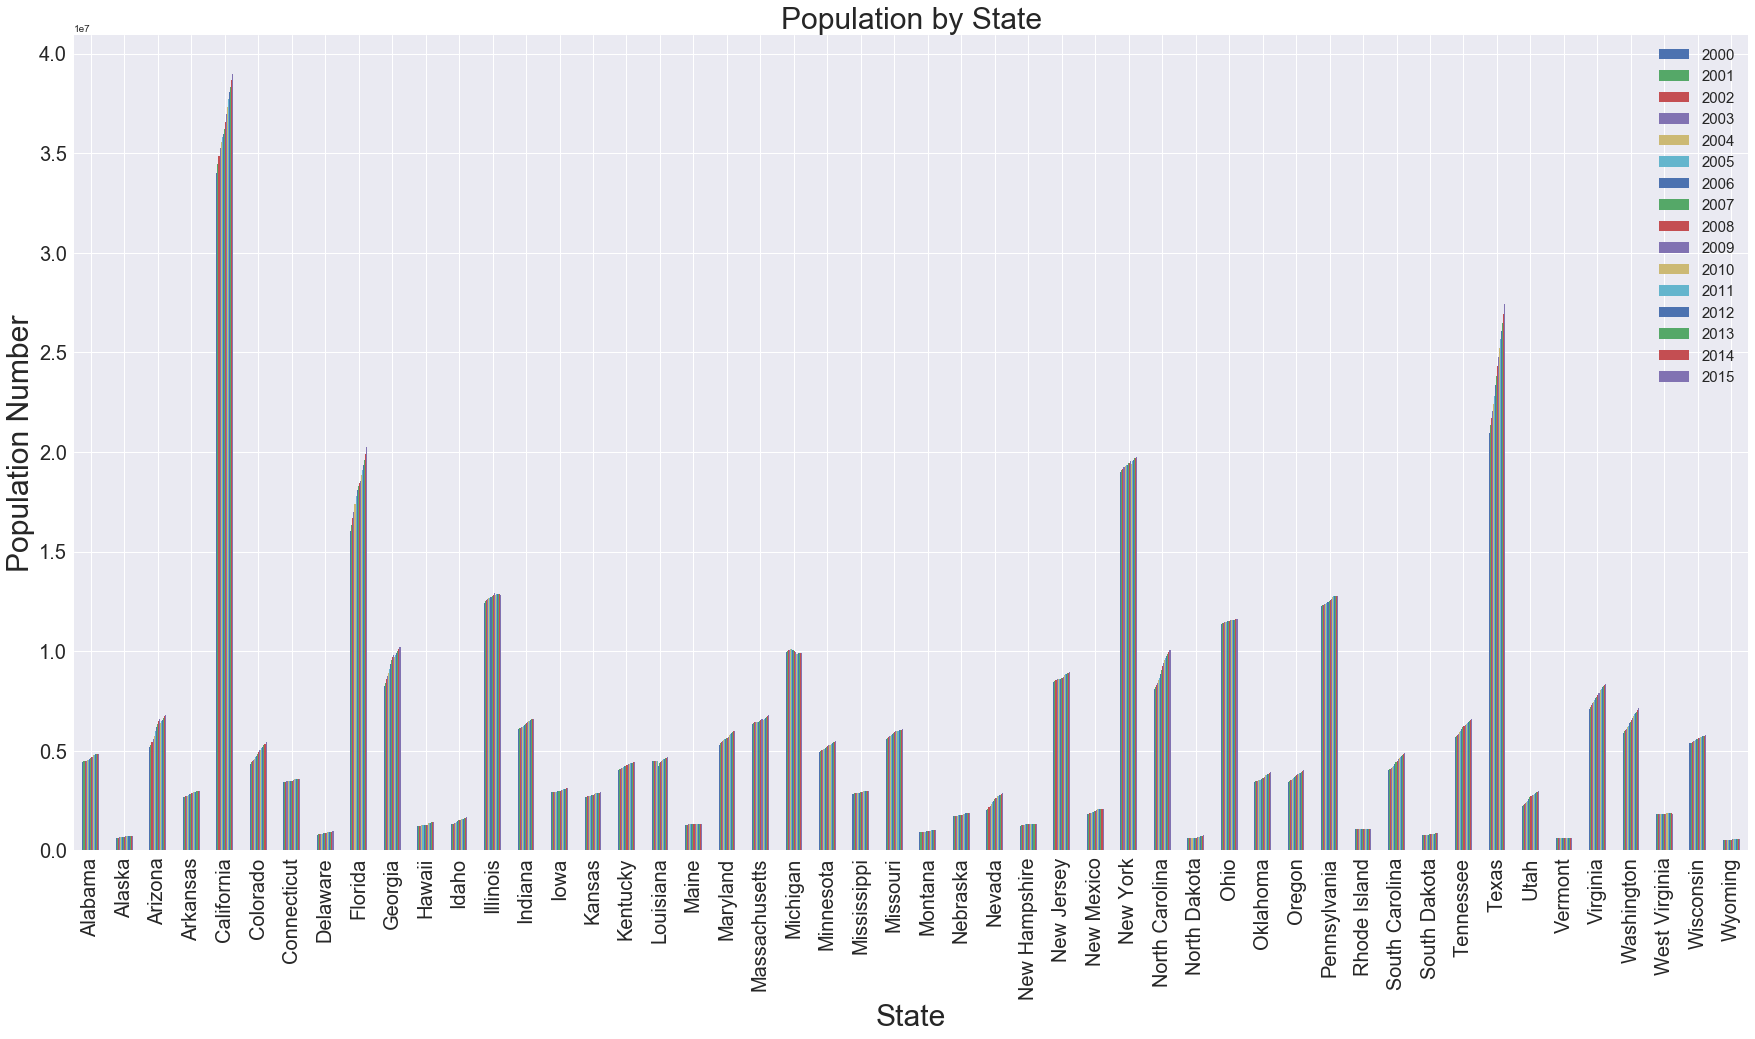

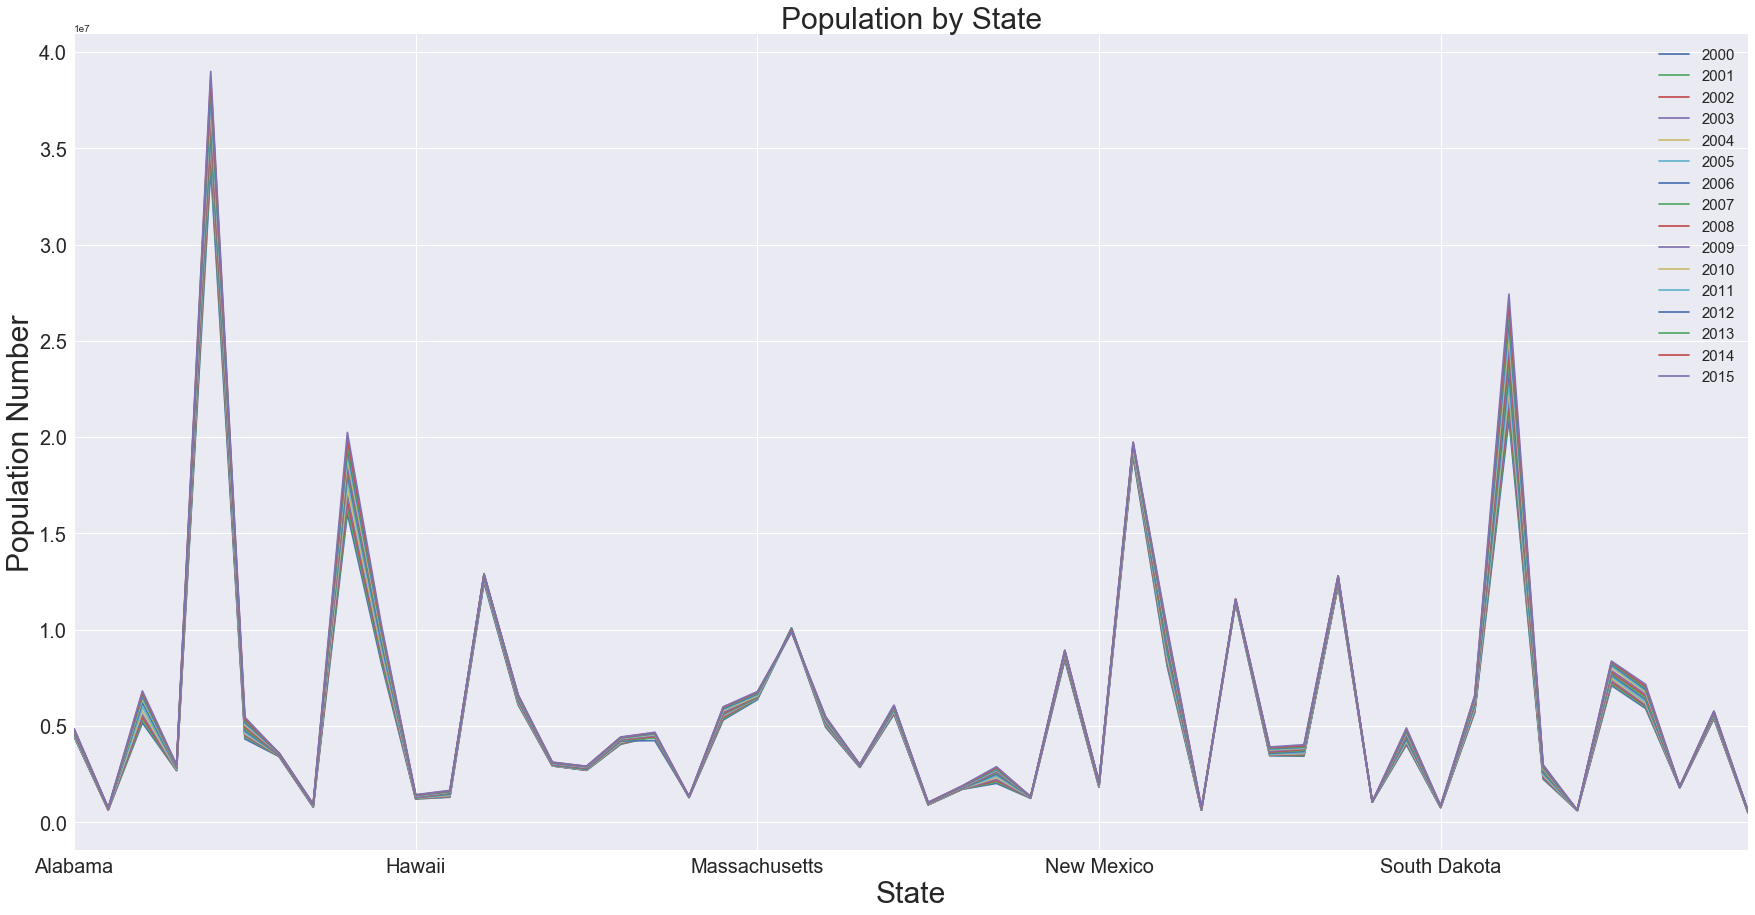

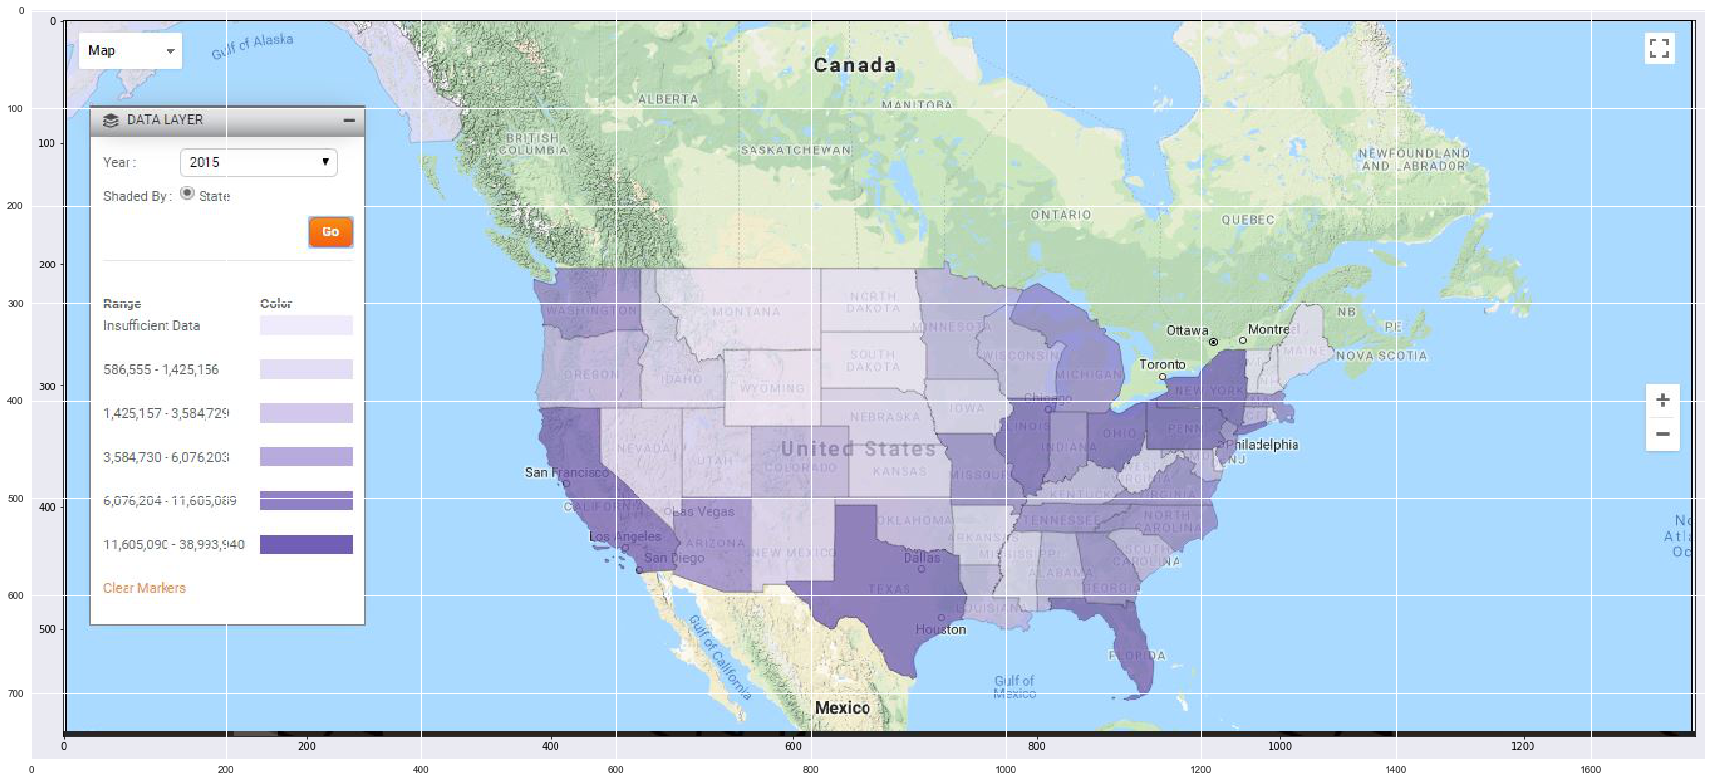

In [10]:
#Plotting Population To Differentiate Between State
#Plotting simpleb bar graph
populationDF.plot.bar(figsize=(30, 15), fontsize=20)
plt.title('Population by State', fontsize=30)
plt.xlabel('State', fontsize=30)
plt.ylabel('Population Number', fontsize=30)
plt.legend(loc=1, prop={'size': 15})
#Graphing the same data as a regular plot
populationDF.plot(figsize=(30, 15), fontsize=20)
plt.title('Population by State', fontsize=30)
plt.xlabel('State', fontsize=30)
plt.ylabel('Population Number', fontsize=30)
plt.legend(loc=1, prop={'size': 15})
plt.show()

#printing picture that shows the population of all states in 2015
fig = plt.gcf()
fig.set_size_inches(30, 15)
img=mpimg.imread('Data/population.jpg')
imgplot = plt.imshow(img)

plt.show()

The first two graphs are effective in showing us how the states compare in terms of population. As we can see, the states with the most population are California, New York, Florida, and Texas.

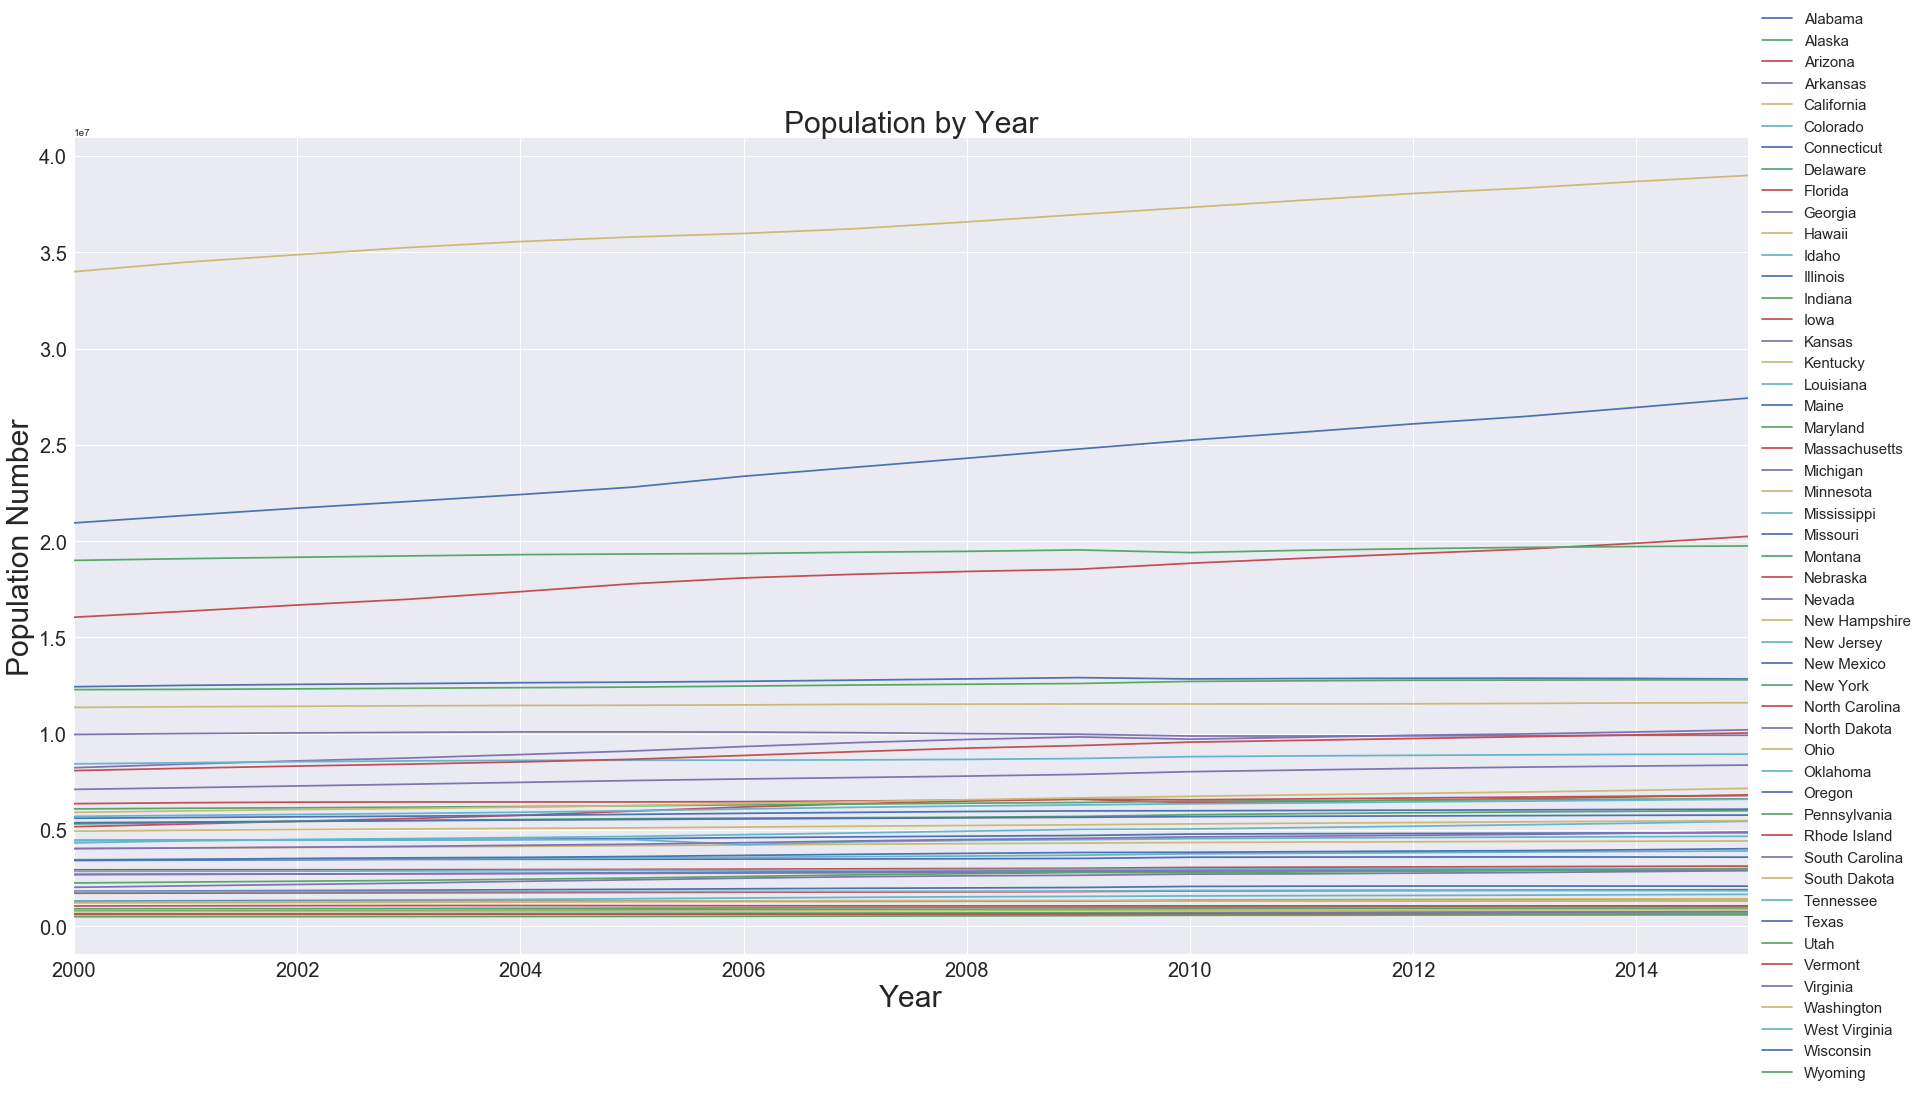

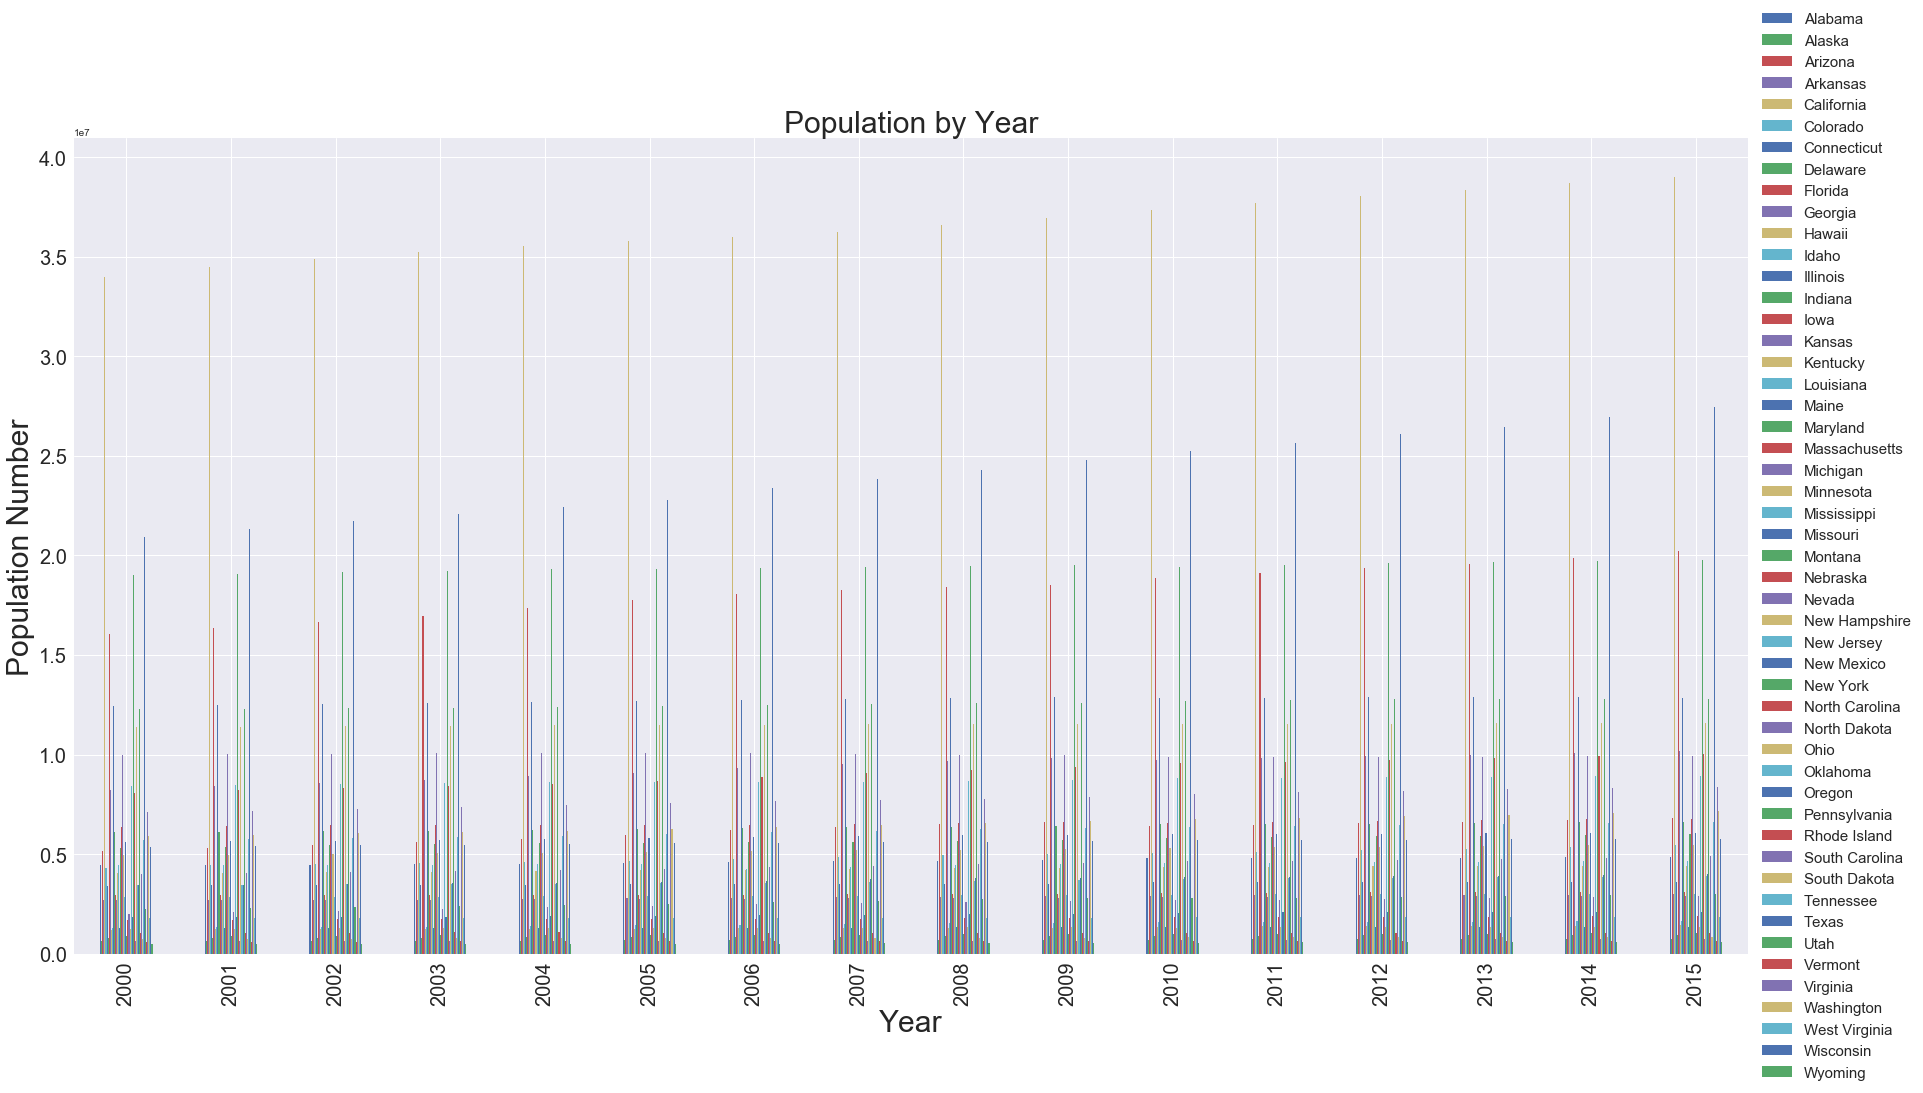

In [11]:
#Population displayed by different year
#This will graph the population dataframe again but this time by transposing the state for year
#Graphing using regular plot

pop = populationDF.T
pop.plot(figsize=(30, 15), fontsize=20)
plt.title('Population by Year', fontsize=30)
plt.xlabel('Year', fontsize=30)
plt.ylabel('Population Number', fontsize=30)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), prop={'size': 15})

#Graphing transposed dataframe as a bar graph
pop.plot.bar(figsize=(30, 15), fontsize=20)
plt.title('Population by Year', fontsize=30)
plt.xlabel('Year', fontsize=30)
plt.ylabel('Population Number', fontsize=30)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), prop={'size': 15})
plt.show()

These graphs take the population like the previous set of graphs but they transpose the state with the year so that we are able to see the trends that apply to the states year by year. By taking a close look at the visualization we are able to notice that at every state there is an increase in population throughout the years.

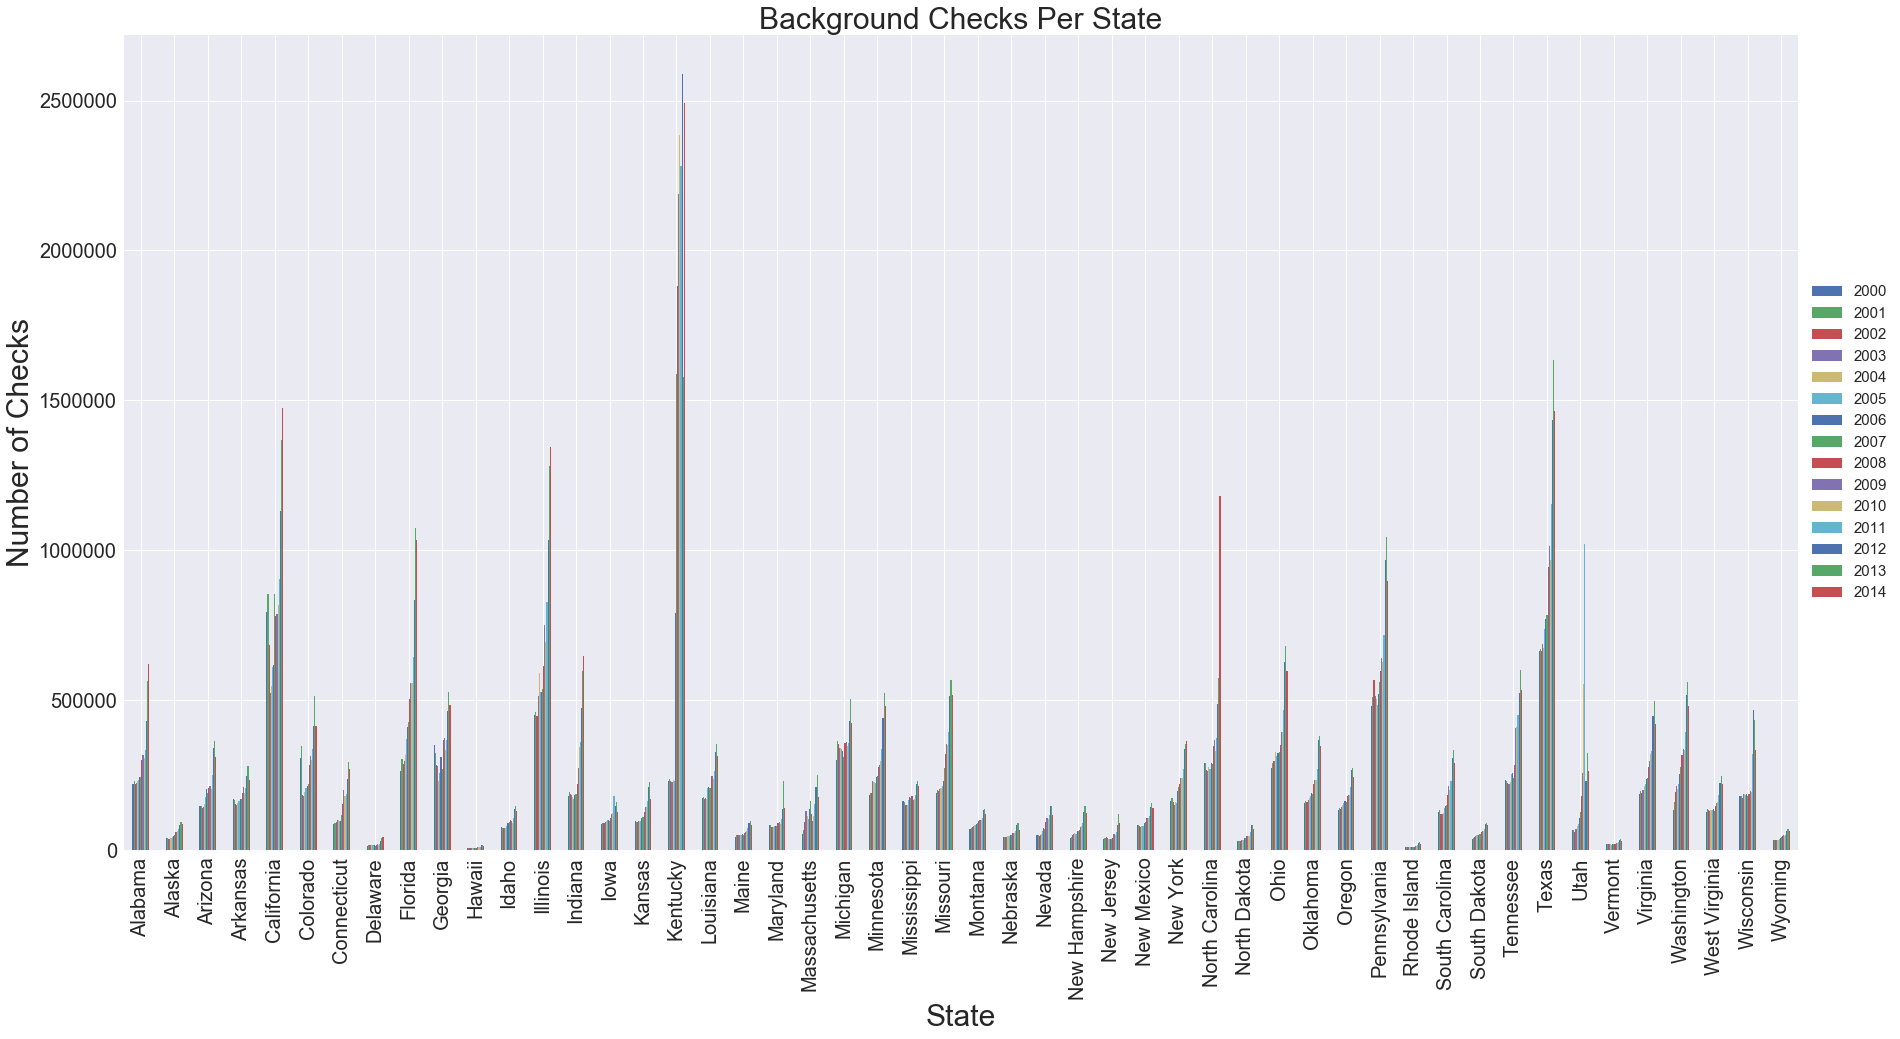

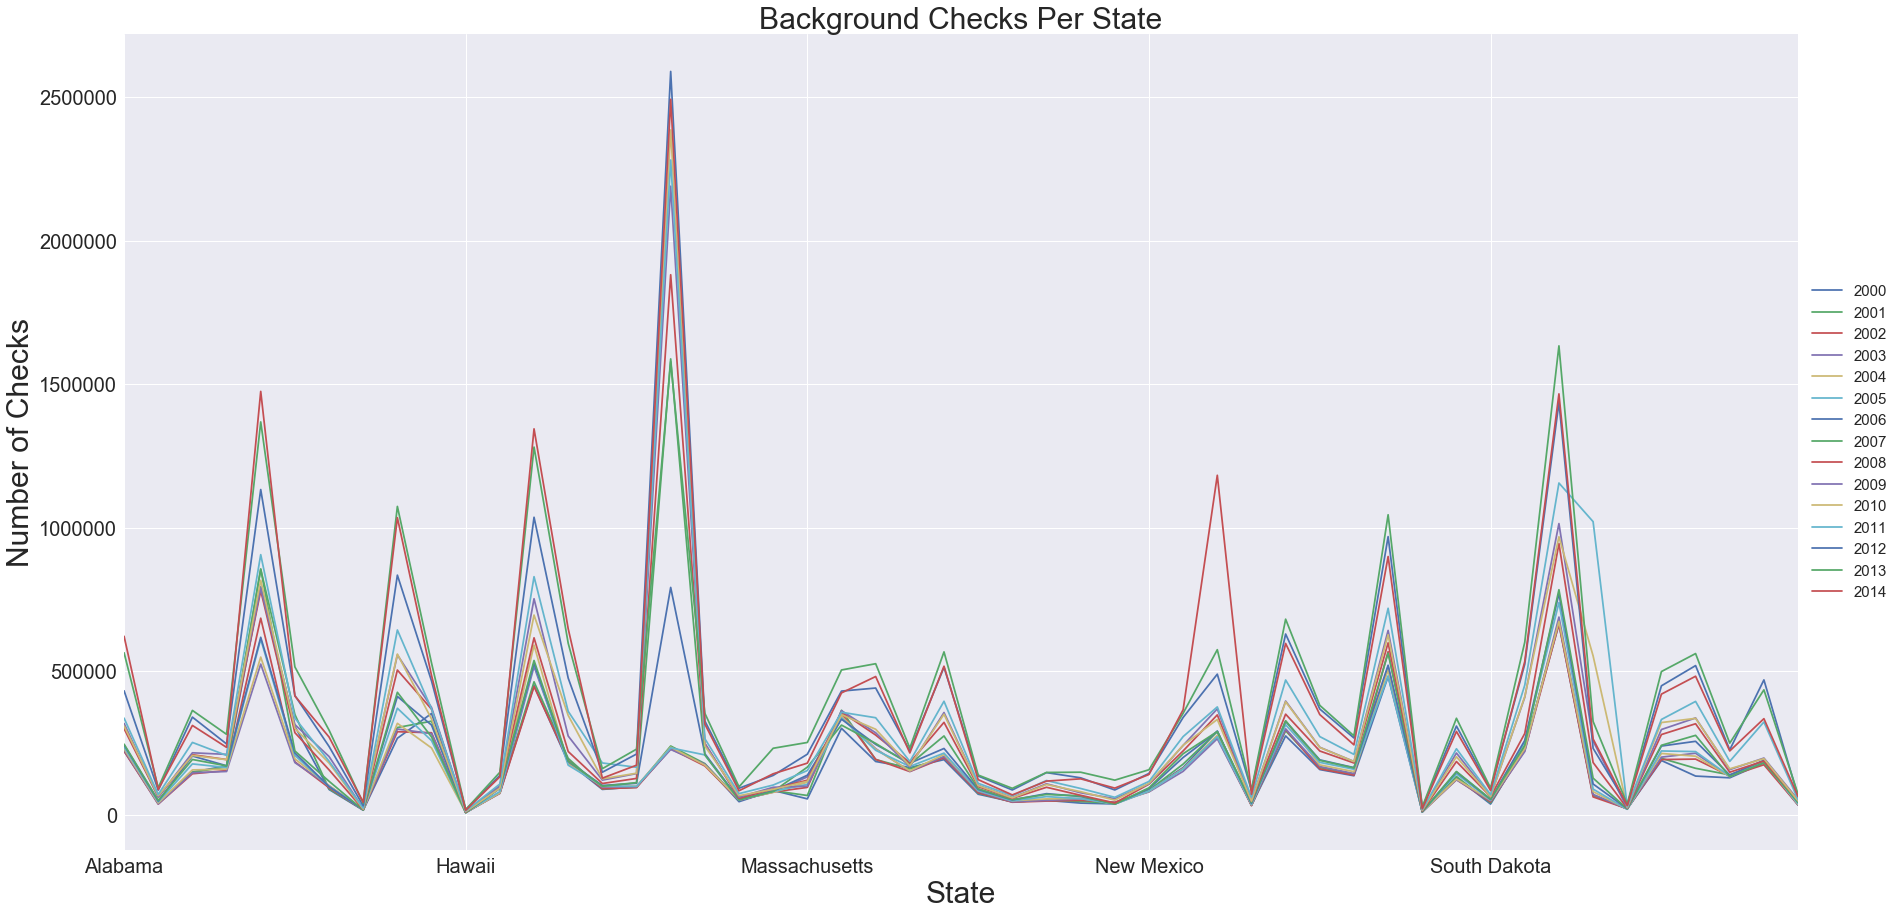

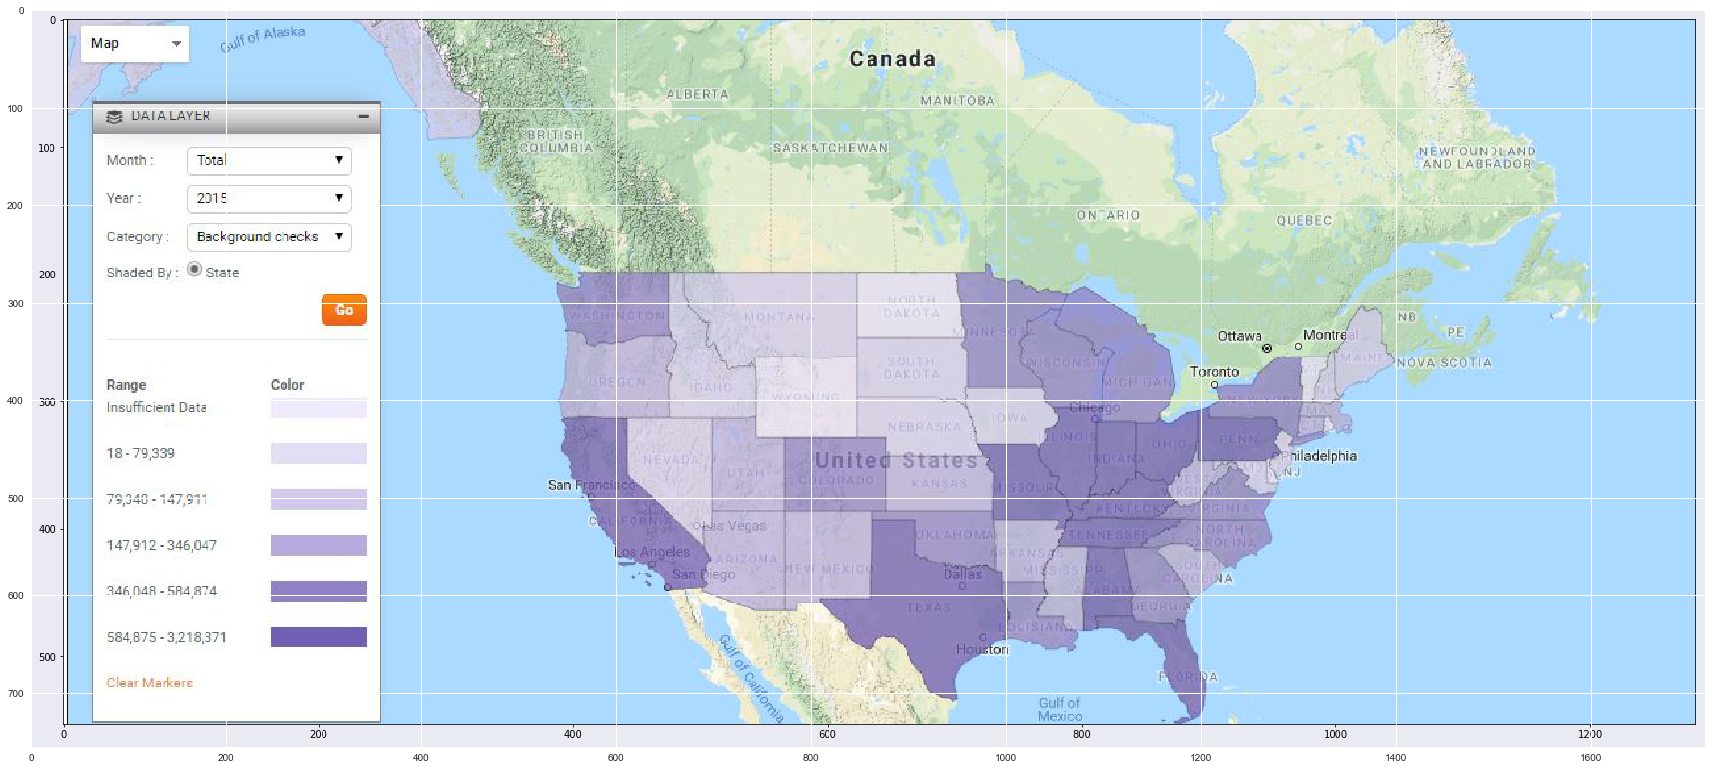

In [12]:
#Number Firearm of background checks per state 
#We take our background check data frame and we plot it using a bar graph by state.
firearmBgChecksDF.plot.bar(figsize=(30, 15), fontsize=20)
plt.title('Background Checks Per State', fontsize=30)
plt.xlabel('State', fontsize=30)
plt.ylabel('Number of Checks', fontsize=30)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), prop={'size': 15})

#We take the same dataframe but we graph it using a regular plot graph.
firearmBgChecksDF.plot(figsize=(30, 15), fontsize=20)
plt.title('Background Checks Per State', fontsize=30)
plt.xlabel('State', fontsize=30)
plt.ylabel('Number of Checks', fontsize=30)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), prop={'size': 15})
plt.show()

#This will show the map of the US for the year 2015 showing the amount of background checks
fig = plt.gcf()
fig.set_size_inches(30, 15)
img=mpimg.imread('Data/2015bgchk.jpg')
imgplot = plt.imshow(img)

plt.show()

These set of graphs are able to show us the difference amongst states in terms of how many background checks they perform each year. It is interesting to see that Kentucky is a noticable leader in background checks throughout the years. Throught the visualization we are also able to pinpoint the states witht the most background checks throughout the years which are: Kentucky, California, Texas, and Illinois. 

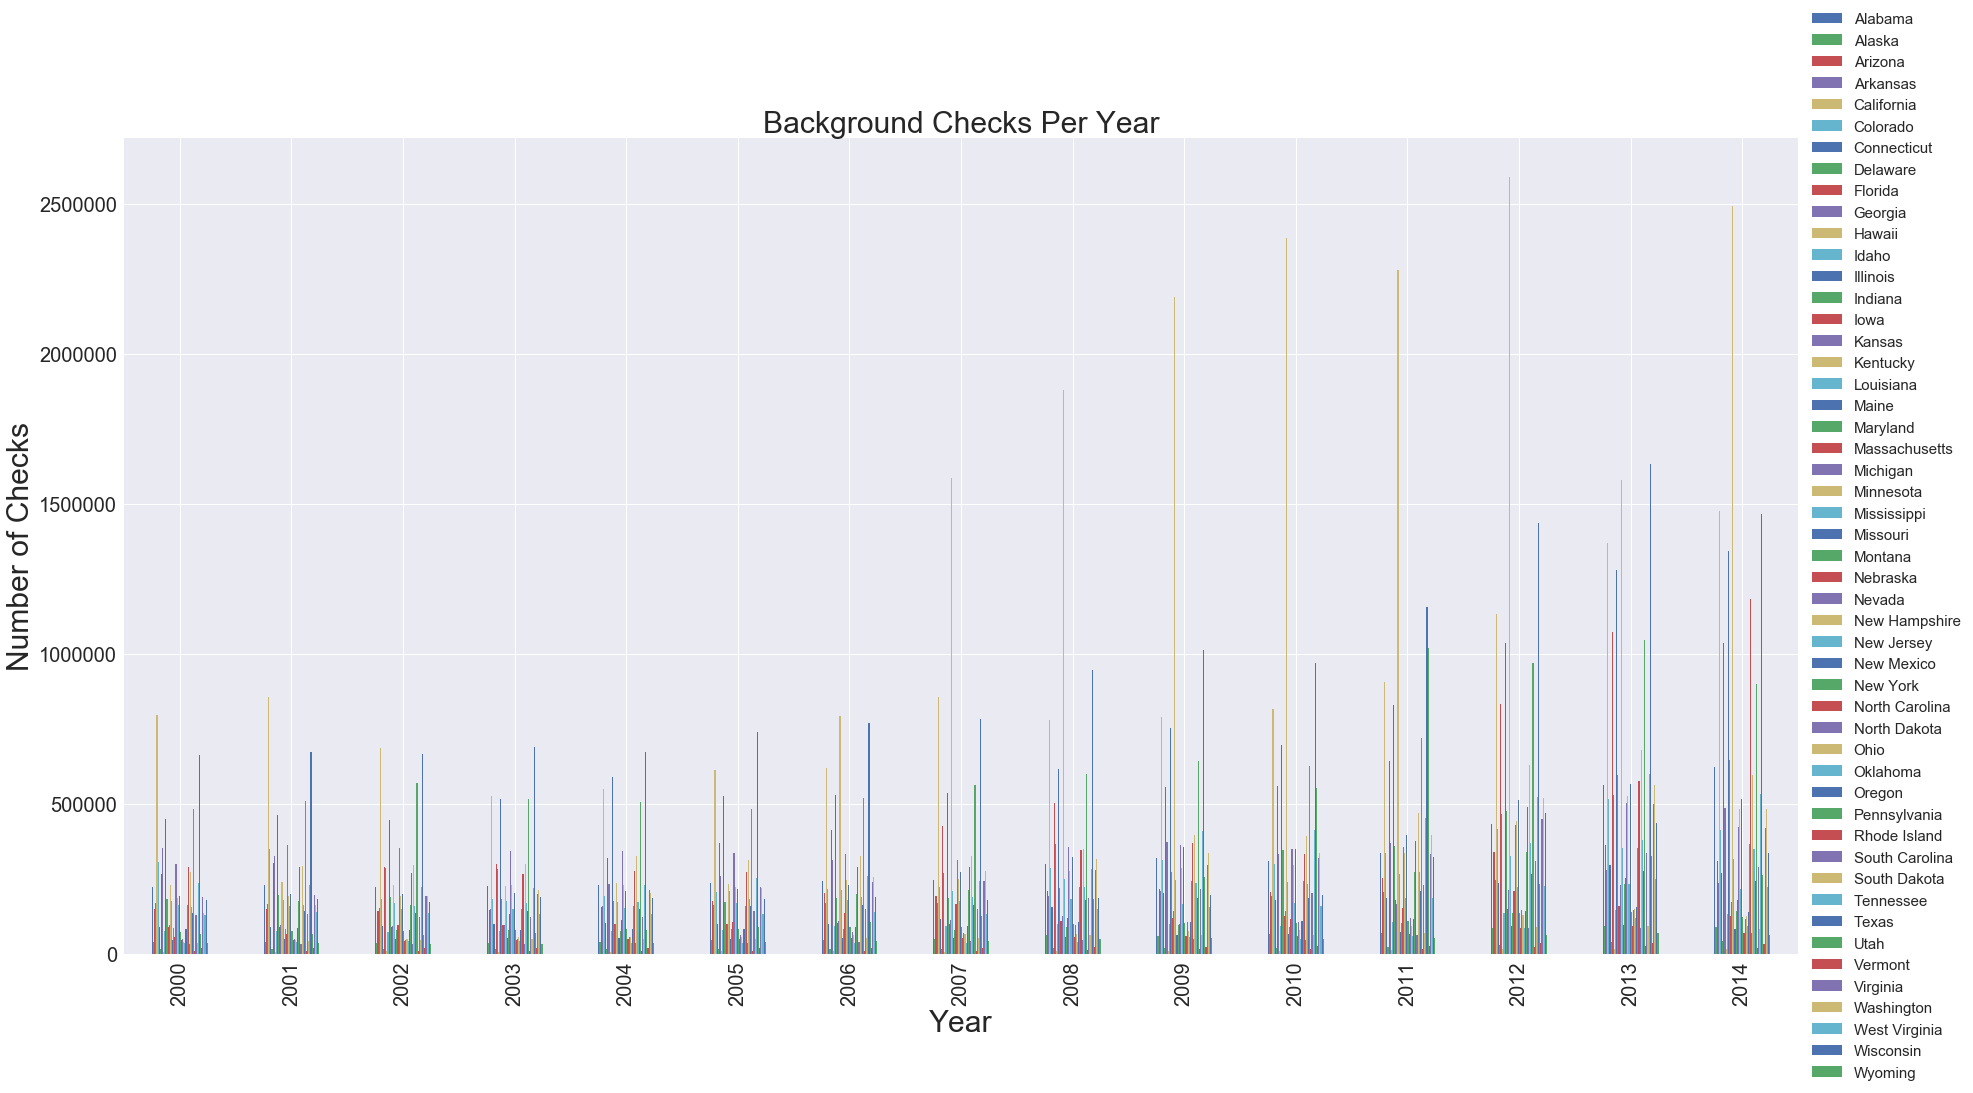

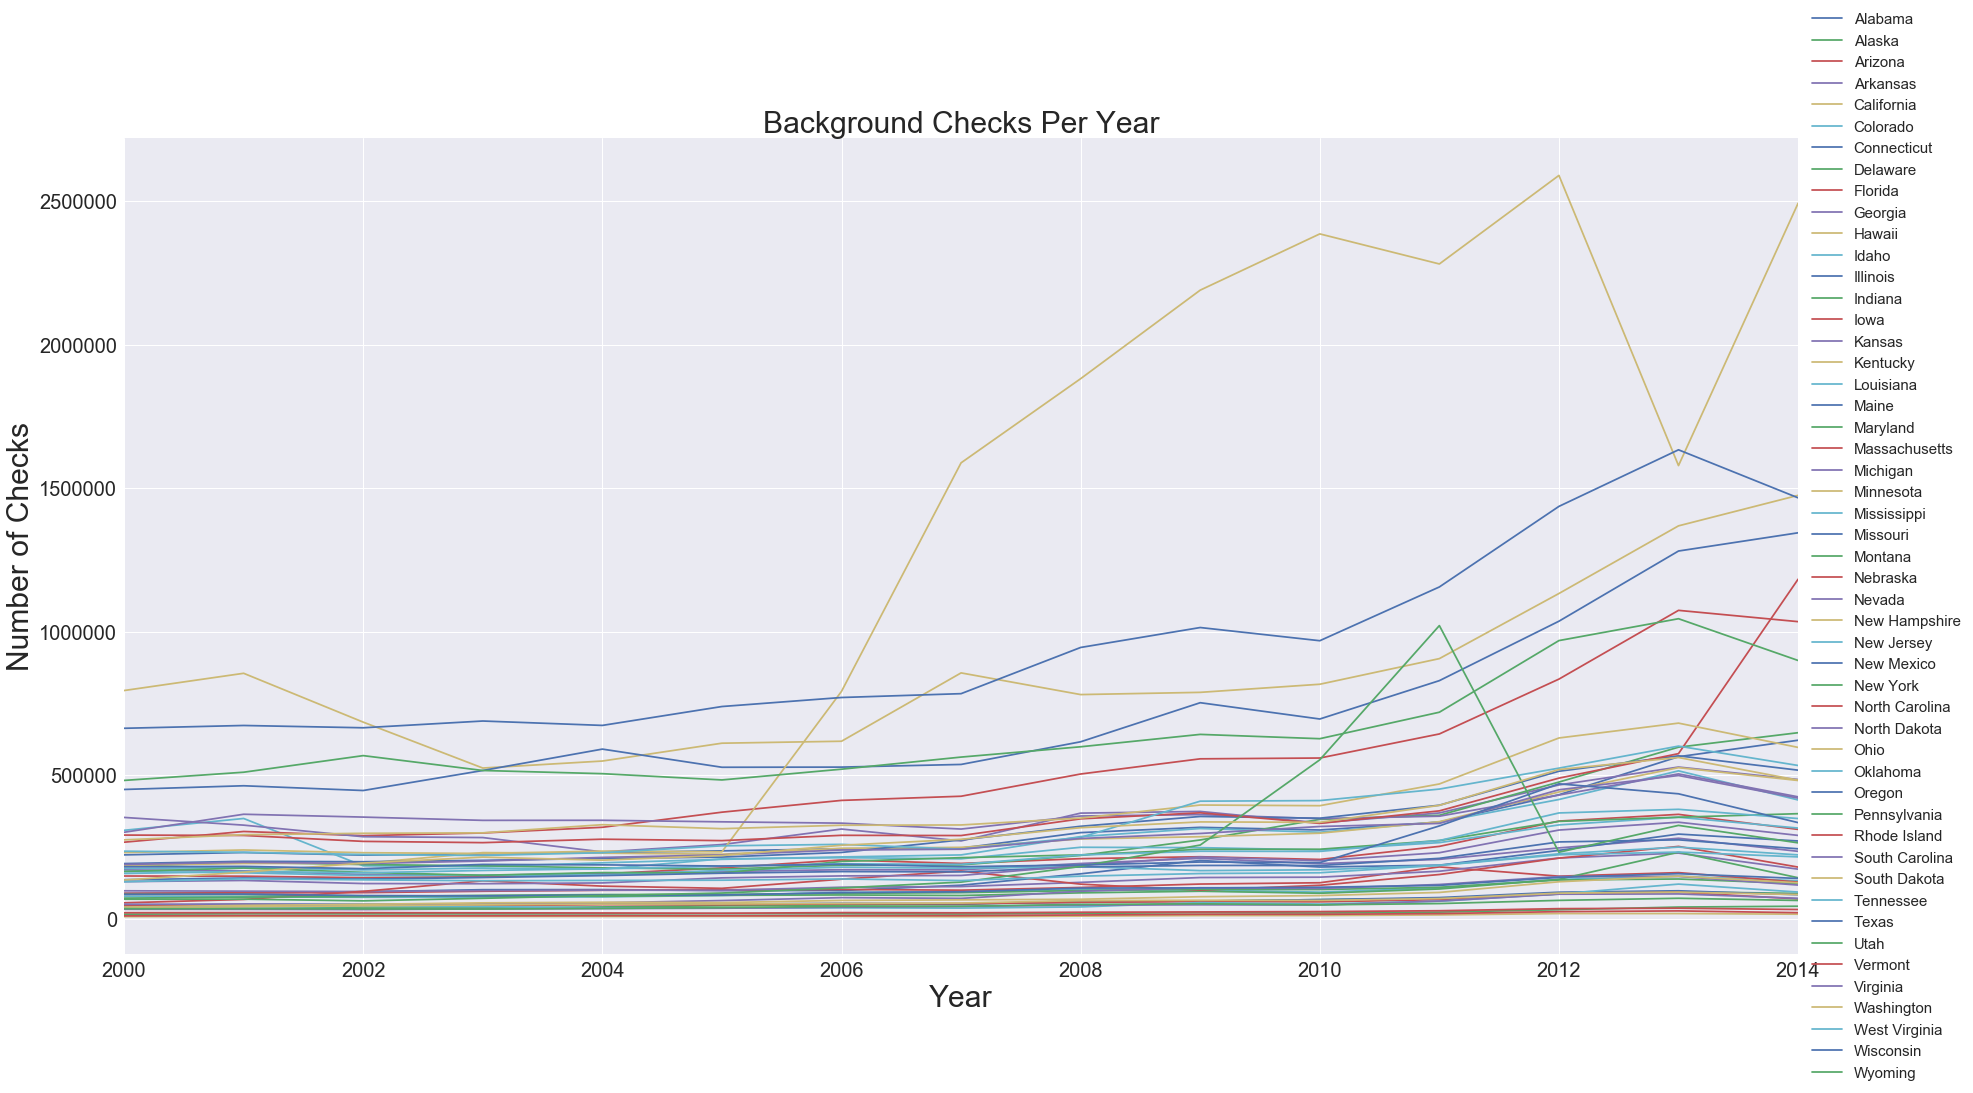

In [13]:
#Fire Arm Background Checks by Year
#This code will create a bar graph using the Fire Arm Background Checks as well except you are transposing the state with the year.
fire = firearmBgChecksDF.T
fire.plot.bar(figsize=(30, 15), fontsize=20)
plt.title('Background Checks Per Year', fontsize=30)
plt.xlabel('Year', fontsize=30)
plt.ylabel('Number of Checks', fontsize=30)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), prop={'size': 15})


#Here we are plotting the same data except we are using a regular plot
fire.plot(figsize=(30, 15), fontsize=20)
plt.title('Background Checks Per Year', fontsize=30)
plt.xlabel('Year', fontsize=30)
plt.ylabel('Number of Checks', fontsize=30)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), prop={'size': 15})


plt.show()

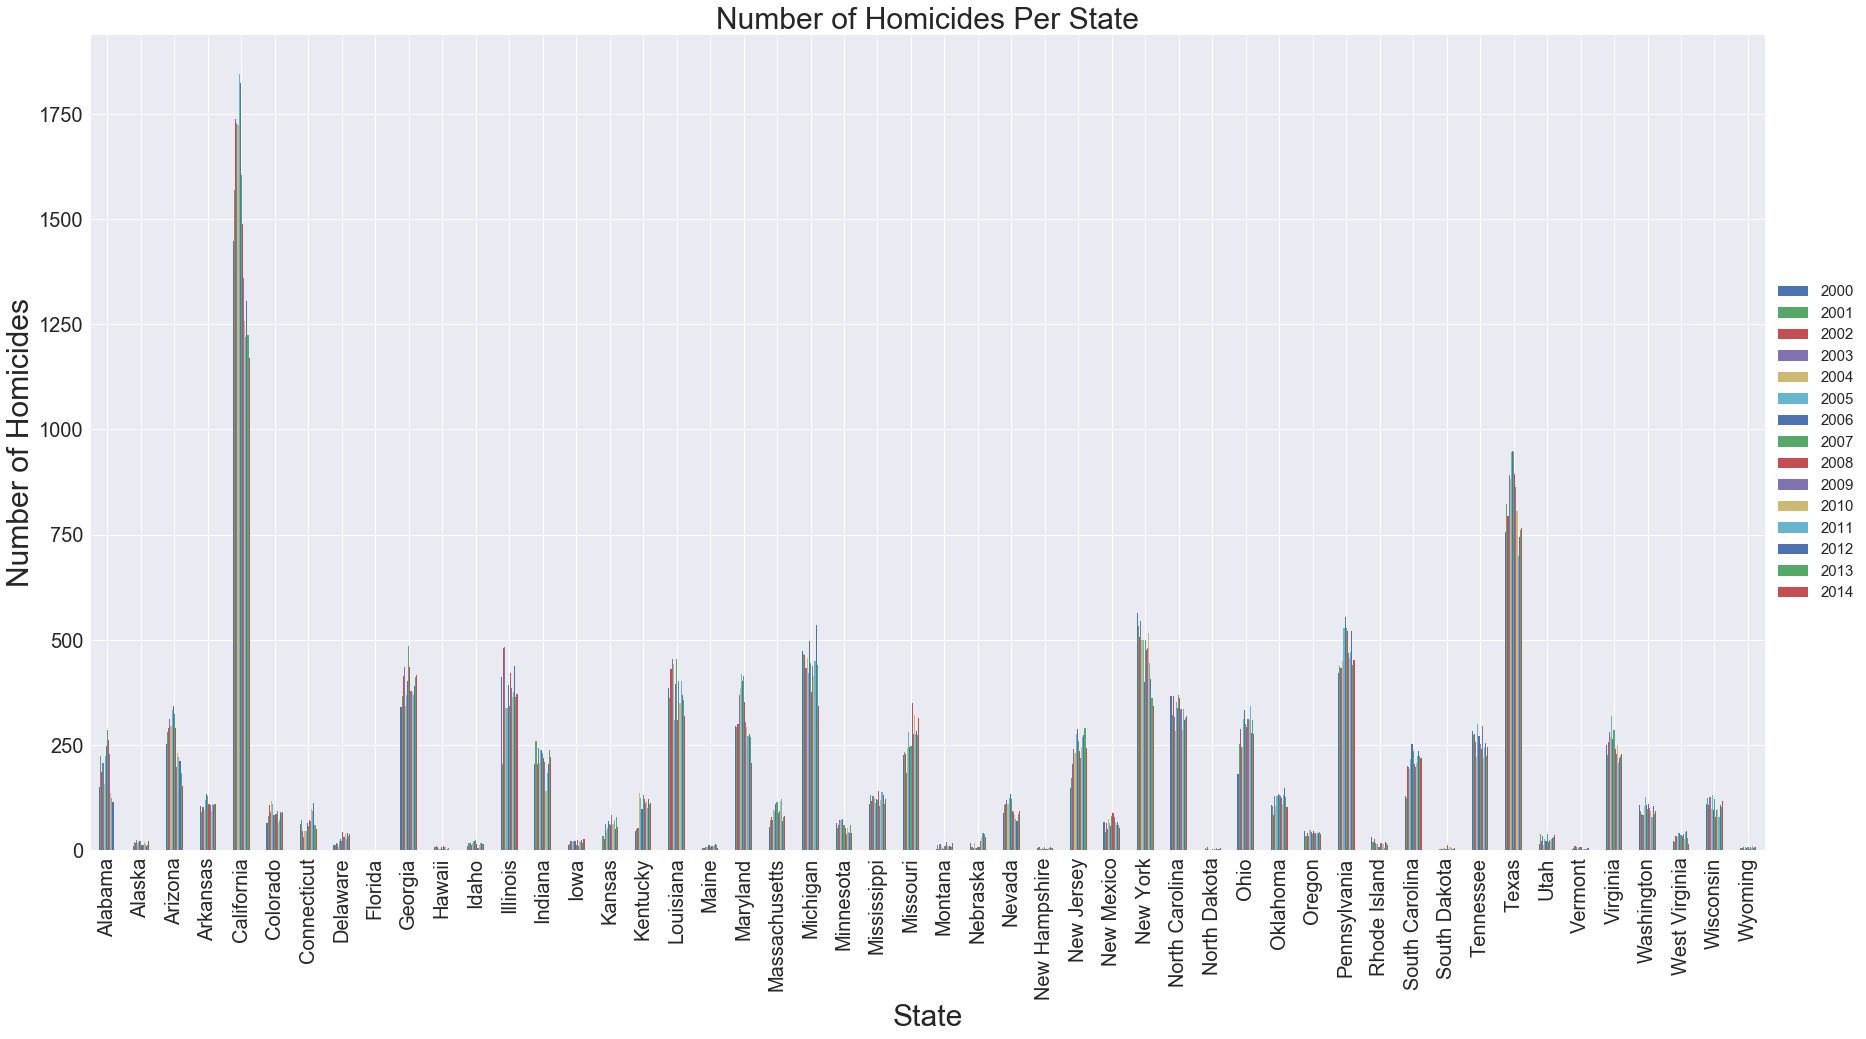

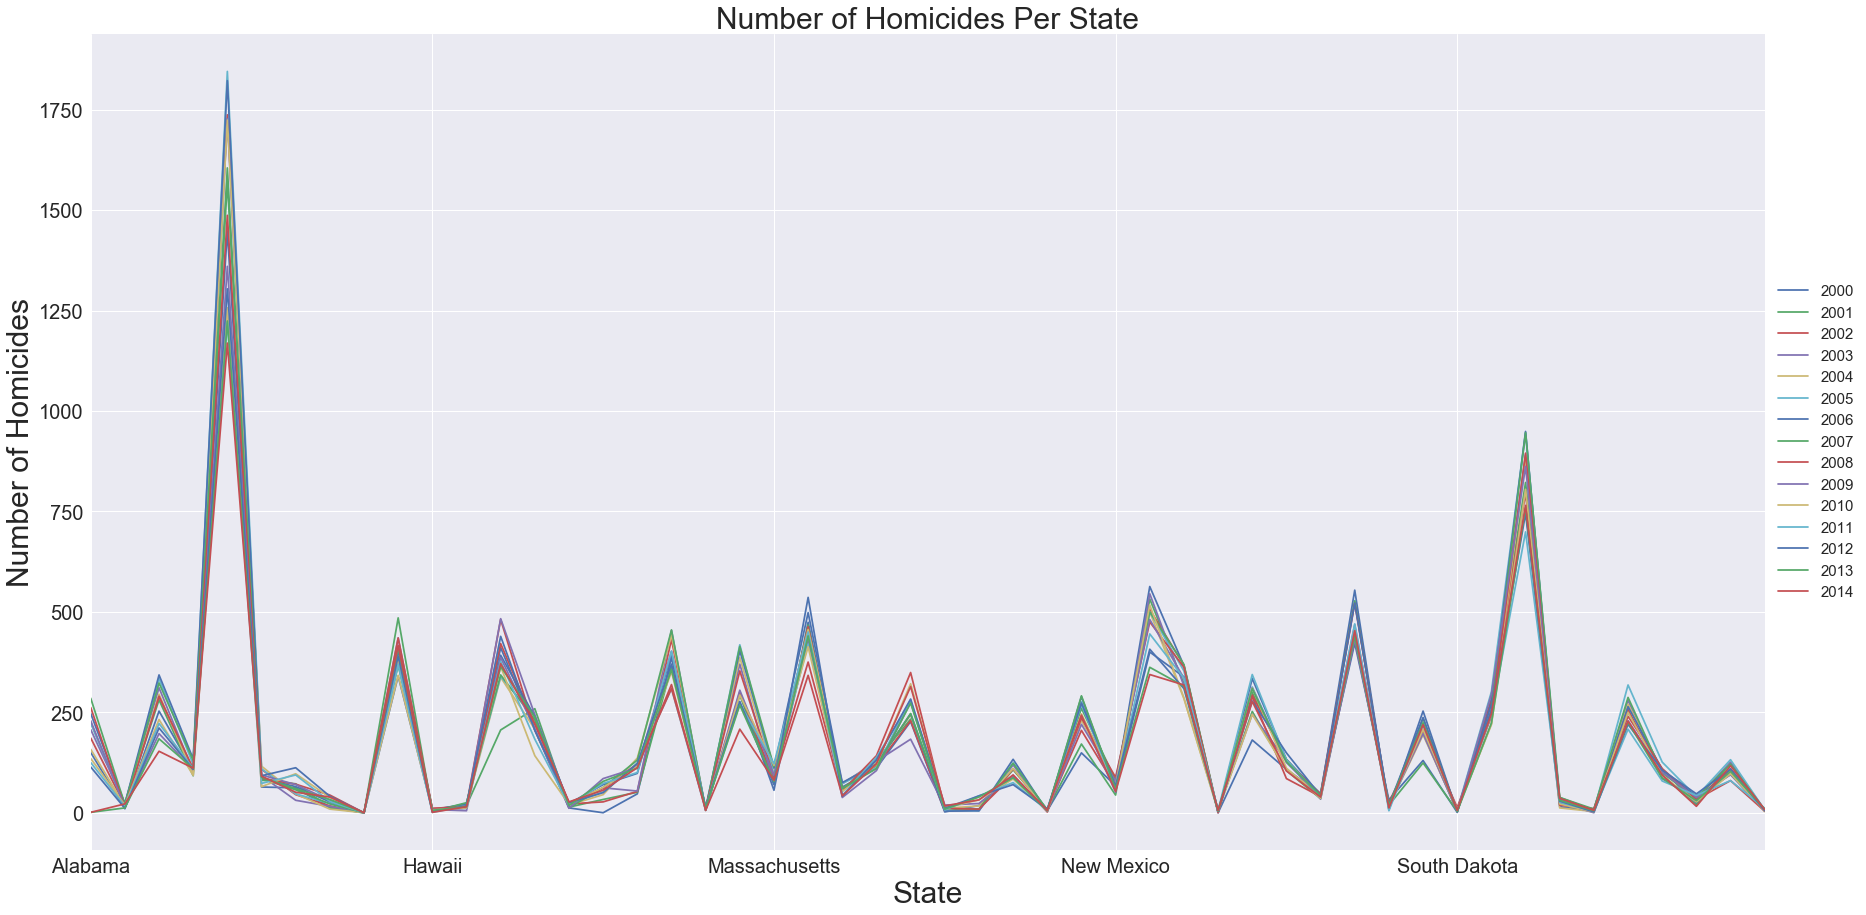

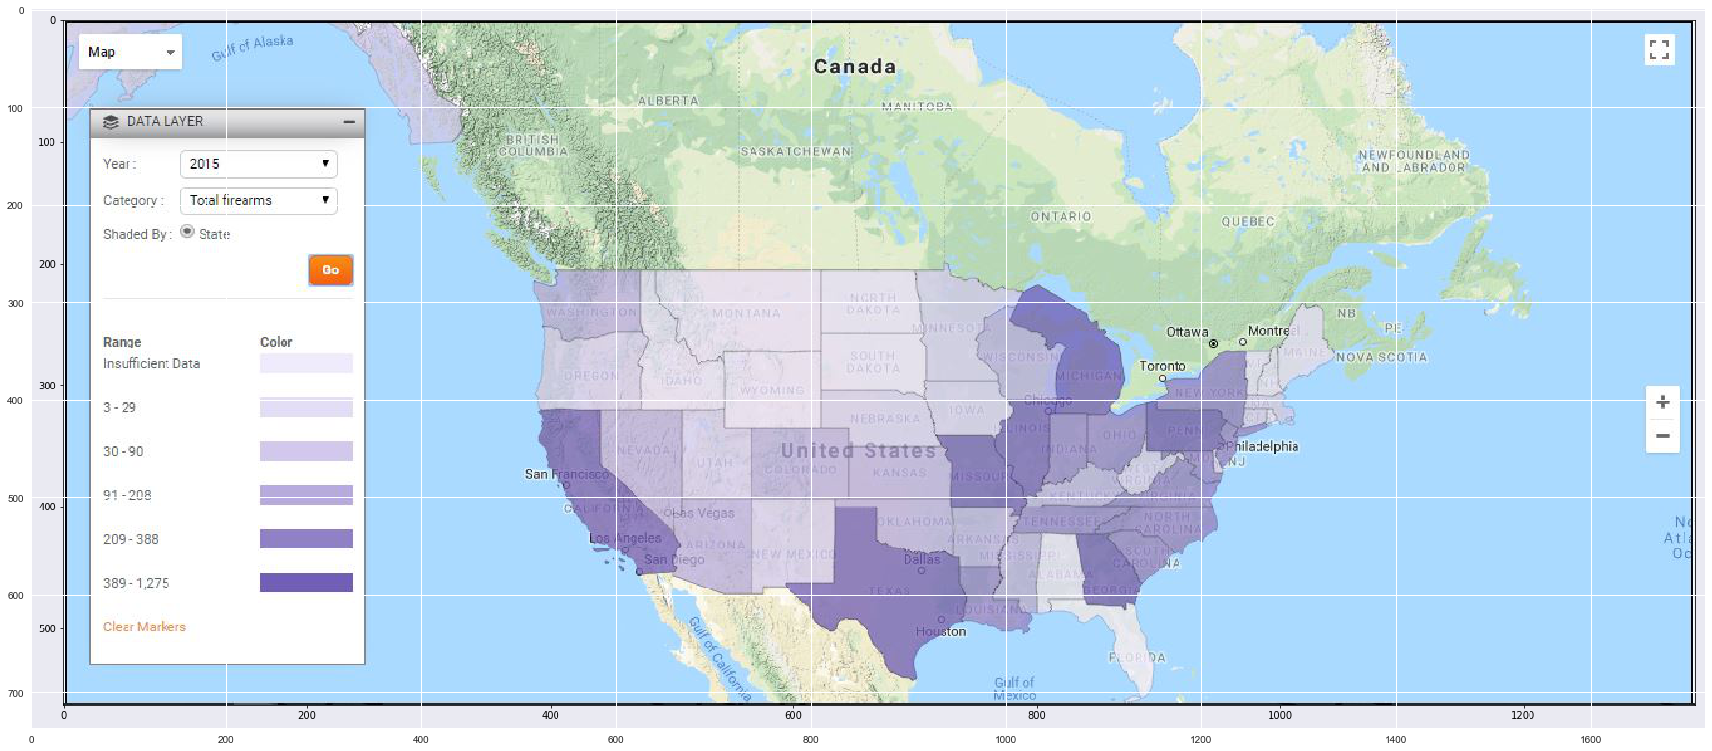

In [14]:
#Number of Homicides Per State
#This portion of the code creates a bar graph showing number of homicides per state
homicidesDF.plot.bar(figsize=(30, 15), fontsize=20)
plt.title('Number of Homicides Per State', fontsize=30)
plt.xlabel('State', fontsize=30)
plt.ylabel('Number of Homicides', fontsize=30)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), prop={'size': 15})

#The same dataframe is used to make a simple graph showing homicides per state
homicidesDF.plot(figsize=(30, 15), fontsize=20)
plt.title('Number of Homicides Per State', fontsize=30)
plt.xlabel('State', fontsize=30)
plt.ylabel('Number of Homicides', fontsize=30)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), prop={'size': 15})
plt.show()

#This will give you a map indicating where more homicides by firearm were commited
fig = plt.gcf()
fig.set_size_inches(30, 15)
img=mpimg.imread('Data/firearm.jpg')
imgplot = plt.imshow(img)

plt.show()

These visualizations are effective in showing us the states with the most number of homicides. By the visualizations we can see that most of the homicides are created in the states with the higher amount of population. We can also see that the leaders in this category are California, Texas, and New York. 

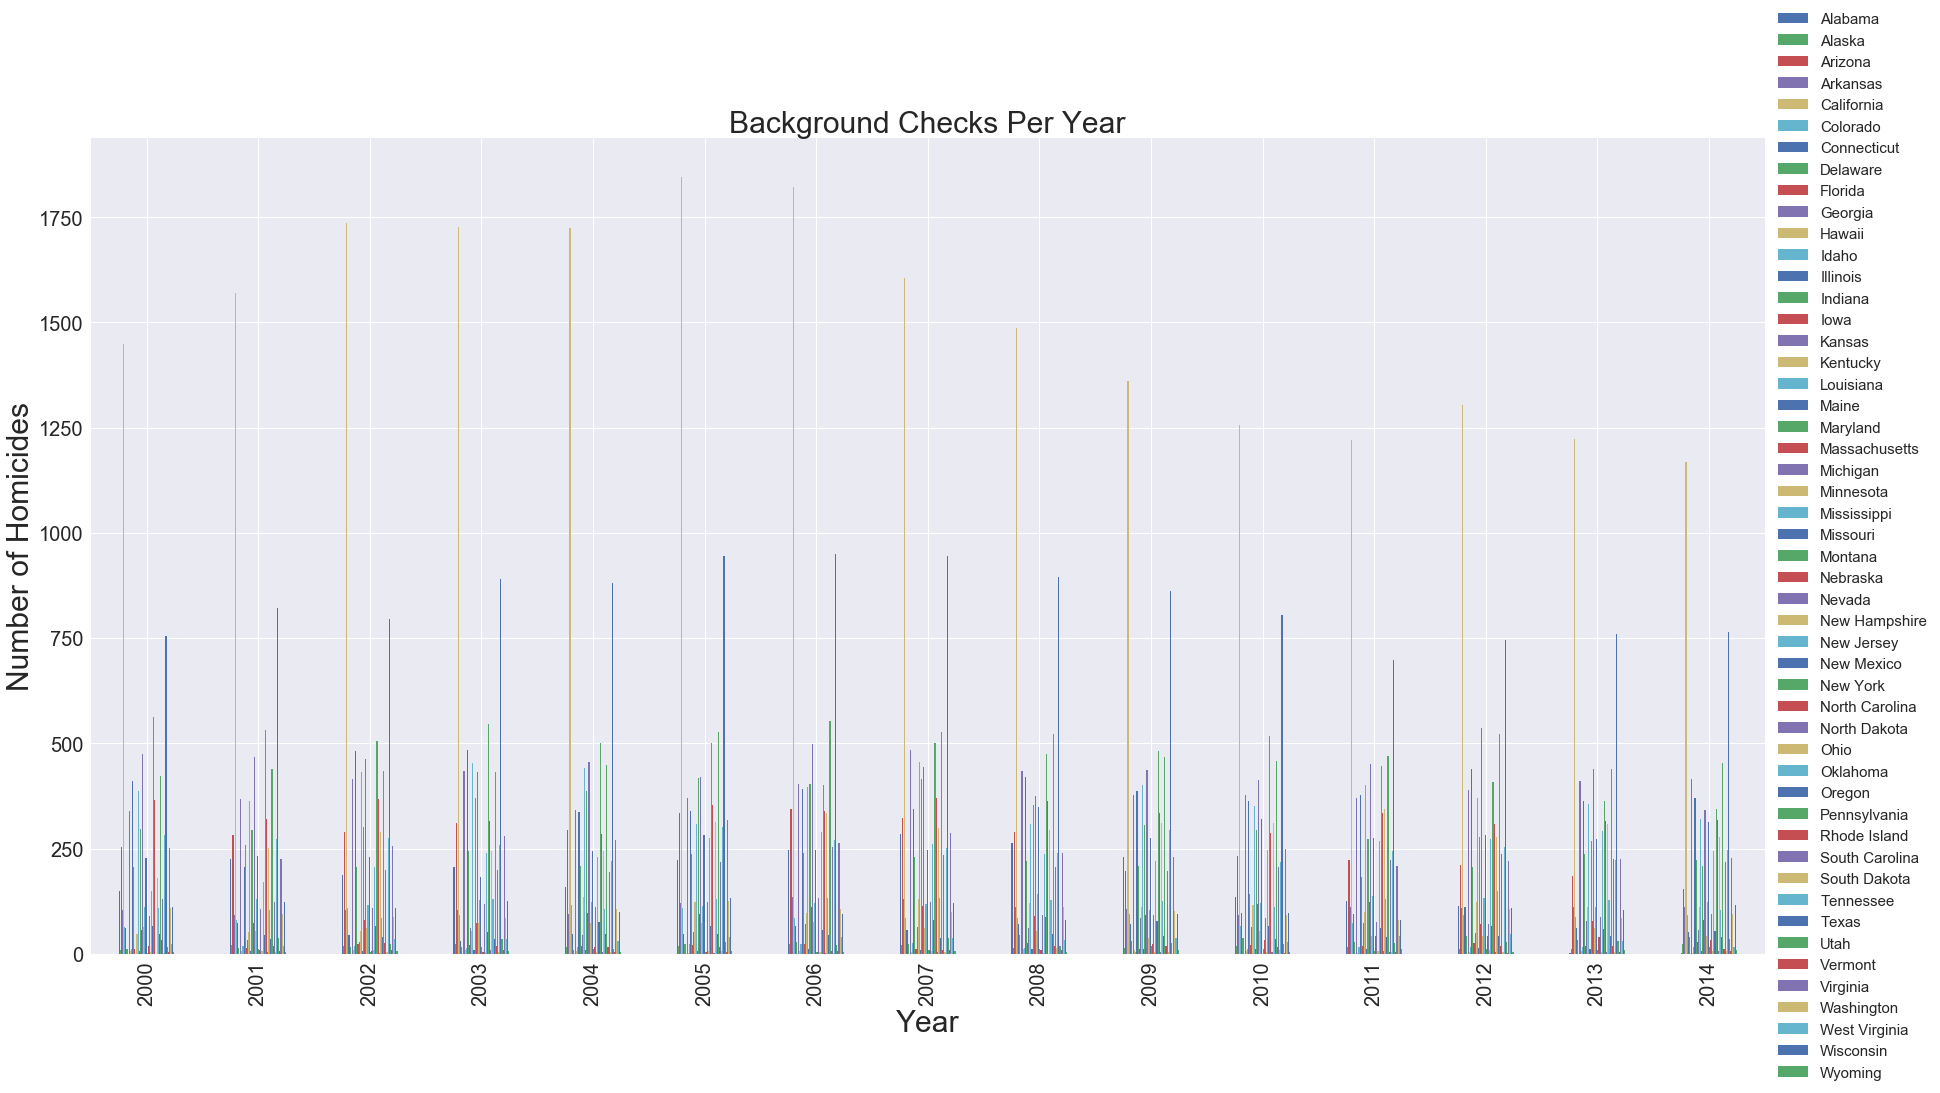

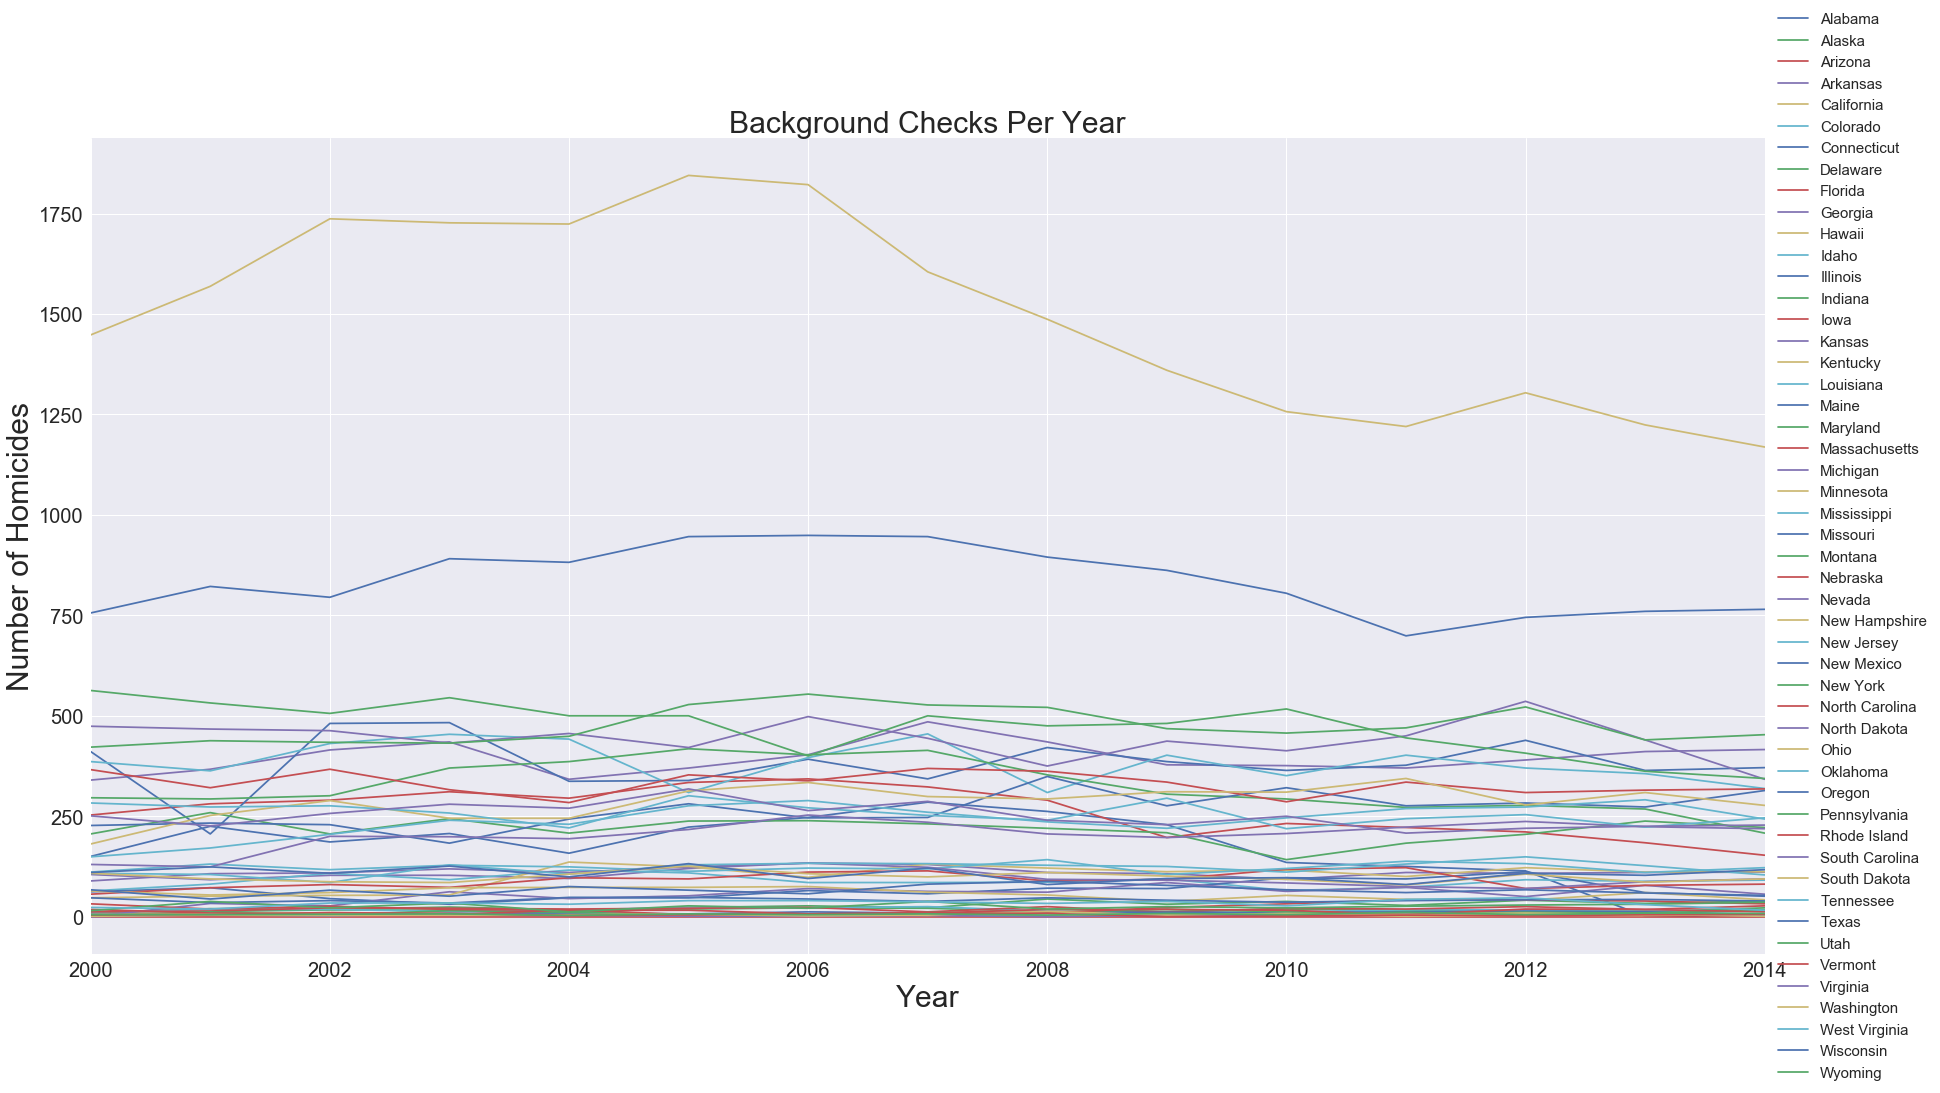

In [15]:
#This portion of the code transposes the homicide dataframe by changing the state with the year. 
#Plotting bar graph with transposed dataframe
hom = homicidesDF.T
hom.plot.bar(figsize=(30, 15), fontsize=20)
plt.title('Background Checks Per Year', fontsize=30)
plt.xlabel('Year', fontsize=30)
plt.ylabel('Number of Homicides', fontsize=30)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), prop={'size': 15})

#Here we can see a regular plot that shows homicide by year
hom.plot(figsize=(30, 15), fontsize=20)
plt.title('Background Checks Per Year', fontsize=30)
plt.xlabel('Year', fontsize=30)
plt.ylabel('Number of Homicides', fontsize=30)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), prop={'size': 15})
plt.show()

As we can see by the visualizations, the number of background checks have decreased per year. After the year 2006 we have a decrease in homicides per year.

# Data Analysis

[  5.69196801e-12   2.18826211e-05]


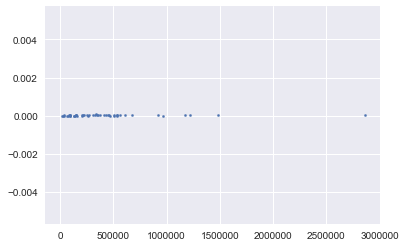

In [16]:
x = cumDF.backgroundChecks
y = cumDF.homicideRates

# fit and test a polynomial regression with 1 degrees of freedom = linear regression

p = np.polyfit(x,y,deg=1)
plt.scatter(x,y,5)

X = np.linspace(0.1,30,num=50)
print(p)
plt.plot(np.linspace(0.1,30,num=50), np.linspace(0.1, 30,num=50)*p[0]+p[1],'r-')
#plt.plot(p)
plt.show()

Plotting cumulative state background checks against cumulative homicide rates using linear values does not yield a useful data visualization, so we will need to apply the natural log function and re-plot the data.


In [17]:
logcumDF = cumDF
logcumDF.at['Florida','homicideRates'] = 0.000001
logcumDF = logcumDF.apply(np.log)
logcumDF.head()

homicideRates  backgroundChecks  crimeRateDF
State                                                   
Alabama        -11.013261         13.138713     1.791759
Alaska         -10.803255         11.410948     1.386294
Arizona        -10.498571         12.707424     1.609438
Arkansas       -10.188214         12.424762     1.609438
California     -10.399732         14.014285     1.386294

The state of Florida consistantly reports 0 homicides, and so to avoid zero division, we here set the value to 0.000001 which is still a minimum in the dataset. We then apply natural log function to the entire dataset to better visualize anda anlyse the relationshp between the variables.

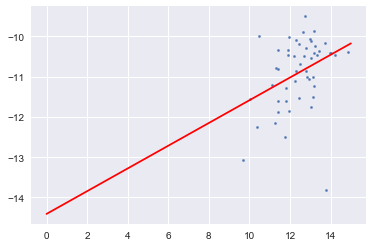

[  0.28238608 -14.40916764]


In [18]:
# modeling homicide rates as a fucntion of background checks

x = logcumDF.backgroundChecks
y = logcumDF.homicideRates

# run first degree polynomial on log-scaled data

p = np.polyfit(x,y,deg=1)
plt.scatter(x,y,5)
plt.plot(np.array([0,15]), np.array([0, 15])*p[0]+p[1],'r-')
plt.show()
print(p)

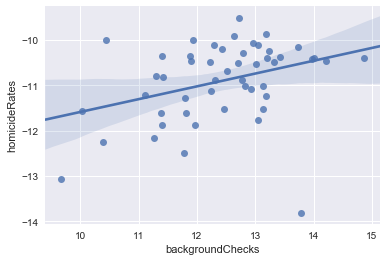

In [19]:
sns.regplot(x,y)
plt.show()

At a first glance, it does seem that a linear model may not be the best line of fit for this data.
Then we tested the correlation between the datasets with a polynomial regression of 0 to 4 degrees of freedom, and found that the line of best fit with the smallest squared error was in fact a constant. This indicates that there is no correlation in these data between the number of firearm background check per state and state homicide rates.
We displayed cumulative state background checks against cumulative state homicide rates on a scatter plot. Once again, our p value did not reach significance, confirming the lack of correlation between the datasets.


In [20]:
def poly_predict(x,p):
    """polynomial regression"""
    y = np.zeros(np.shape(x))
    for ip in range(len(p)):
        y = y + p[ip]* (x**(len(p)-ip-1))
        
    return y

def check_p_val(p_val,alpha):
    """check pval for one coefficiant"""
    p_val = res.pvalues[1]
    if p_val < alpha:
        lm = True
    else:
        lm = False
    return lm


def check_p_vals(p_val,alpha):
    """ckeck pvals for two coefficients"""
    p_val = res.pvalues[1]
    p_val2 = res.pvalues[2]
    if p_val < alpha:
        lm = True
    else:
        lm = False
    if p_val2 < alpha:
        lm2 = True
    else:
        lm2 = False
    return lm,lm2

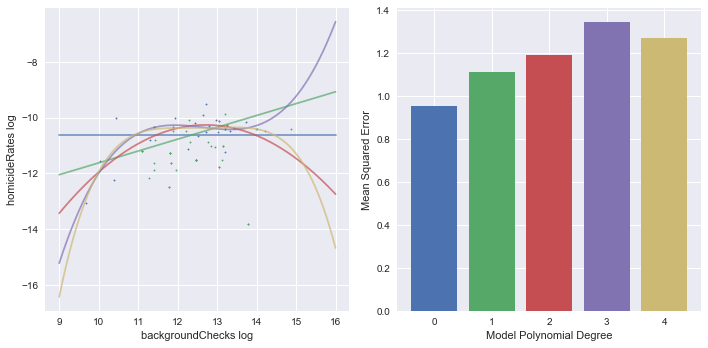

In [21]:
x = logcumDF.backgroundChecks
y = logcumDF.homicideRates

# modeling homicide rates as a function of backgrund checks
#testing poynomial of degrees from 0 to 5 for best line of fit by taking the mean squared error
# over a test and training set of randomly gerenated indices

SEED = 10

np.random.seed(SEED)

test_inds = np.random.randint(0,len(x),50) 
train_inds = np.setdiff1d(np.arange(len(x)), test_inds) 

# grabbing the training and testing data
x_train = x[train_inds]
y_train = y[train_inds]
x_test = x[test_inds]
y_test = y[test_inds]
x_plot = np.arange(9,16,0.01)
max_deg = 5
MSEs = np.zeros(max_deg)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(x_train,y_train,2,alpha=1)
plt.scatter(x_test,y_test,2,alpha=1)
plt.xlabel('backgroundChecks log')
plt.ylabel('homicideRates log')
for degree in range(0,max_deg):
    p = np.polyfit(x_train, y_train, deg=degree)
    y_pred = poly_predict(x_test,p)

    MSEs[degree] = np.mean((y_pred-y_test)**2)
    
    plt.plot(x_plot, poly_predict(x_plot,p), '-', alpha=0.7) 
    #plt.show()
plt.subplot(1,2,2)

# plot and compare mse
plt.bar(np.arange(max_deg),MSEs, color= plt.rcParams['axes.prop_cycle'].by_key()['color'][:max_deg])
plt.xlabel('Model Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.tight_layout()
plt.show()

Judging from the test above, in which the best line of fit is tested with polynomial regresion of 0 to 4 degrees of freedom, we can conclude that the line that produces the least mean squared error is in fact a constant and we can conclude that a correlation between homicide rate and amount of background checks for firearms is not visible in the data.

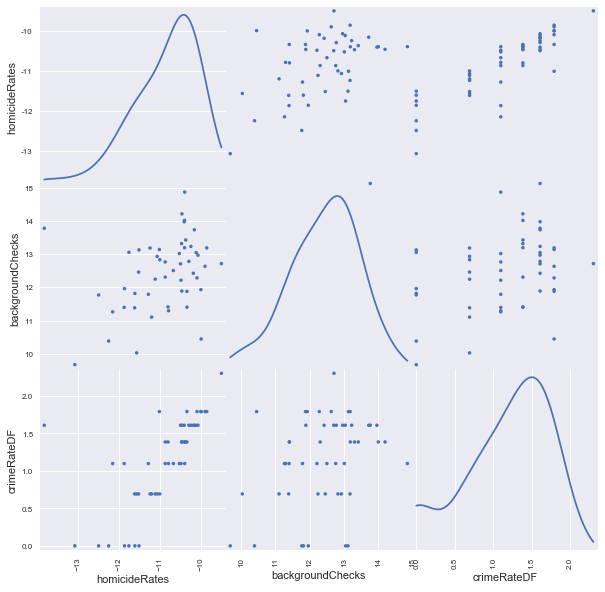

In [22]:
# scatter plot and check for correlated variables
scama = pd.plotting.scatter_matrix(logcumDF, alpha=1, figsize=(10, 10), diagonal='kde')
plt.show()

                            OLS Regression Results                            
Dep. Variable:          homicideRates   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     6.818
Date:                Thu, 22 Mar 2018   Prob (F-statistic):             0.0120
Time:                        23:15:53   Log-Likelihood:                -59.970
No. Observations:                  50   AIC:                             123.9
Df Residuals:                      48   BIC:                             127.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -14.4092      1.348  

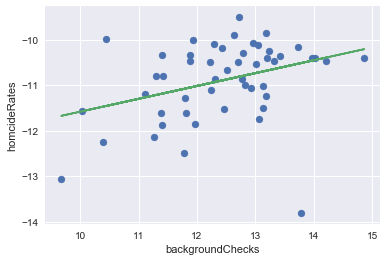

Intercept           2.761696e-14
backgroundChecks    1.200672e-02
dtype: float64
The y variable is significantly different from a null-hypthesis:  False


In [23]:
# modeling homiciderates as a linear function of background checks

y, X = dmatrices('homicideRates ~ backgroundChecks', data=logcumDF, return_type = 'dataframe')

# describe model
mod=sm.OLS(y, X)
# fit model
res = mod.fit()
# look at results
print(res.summary())
yhat = np.dot(X.values, res.params.values)
fig, ax = plt.subplots()
ax.scatter(logcumDF.backgroundChecks, logcumDF.homicideRates)
ax.plot(logcumDF.backgroundChecks, yhat, color='C1')
ax.set_xlabel('backgroundChecks')
ax.set_ylabel('homcideRates')
plt.show()
print(res.pvalues)
pval = check_p_val(res.pvalues,0.01)
print('The y variable is significantly different from a null-hypthesis: ',pval)

                            OLS Regression Results                            
Dep. Variable:          homicideRates   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     23.74
Date:                Thu, 22 Mar 2018   Prob (F-statistic):           7.49e-08
Time:                        23:15:54   Log-Likelihood:                -45.836
No. Observations:                  50   AIC:                             97.67
Df Residuals:                      47   BIC:                             103.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -13.3199      1.043  

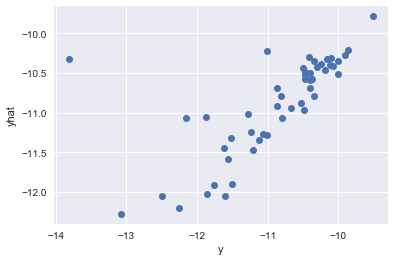

Intercept           6.867064e-17
backgroundChecks    2.240538e-01
crimeRateDF         2.915839e-07
dtype: float64
The y variables are significantly different from a null-hypthesis:  (False, True)


In [24]:
# modeling homicide rates as a multililnear funciton of background checks and crimerates

y, X = dmatrices('homicideRates ~ backgroundChecks + crimeRateDF', data=logcumDF, return_type='dataframe')

# describe model
mod = sm.OLS(y, X)
# fit model
res = mod.fit()
# look at results
print(res.summary())

# predict y values
yhat = res.predict(X.values)

fig, ax = plt.subplots()
ax.plot(y, yhat,'o')
ax.set_xlabel('y')
ax.set_ylabel('yhat')
plt.show()
print(res.pvalues)


pvals = check_p_vals(res.pvalues,0.01)
print('The y variables are significantly different from a null-hypthesis: ',pvals)

In [25]:
res_lm = smf.ols(formula='homicideRates ~ backgroundChecks + crimeRateDF', data=logcumDF).fit(disp=0)
res_lm.summary()
# get detailed results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          homicideRates   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     23.74
Date:                Thu, 22 Mar 2018   Prob (F-statistic):           7.49e-08
Time:                        23:15:55   Log-Likelihood:                -45.836
No. Observations:                  50   AIC:                             97.67
Df Residuals:                      47   BIC:                             103.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -13.3199      1.043    -12.768      0.000     -15.419     -11.221
backgroundChecks     0.1077      0.087      1.232      0.224      -0.068       0.284
crimeRateDF          0.9404      0.157      5.977      0.000       0.624       1.257
==============================================================================
Omnibus:                       75.835   Durbin-Watson:                   2.372
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              938.456
Skew:                          -4.023   Prob(JB):                    1.65e-204
Kurtosis:                      22.640   Cond. No.                         149.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
logcumDF.head()

homicideRates  backgroundChecks  crimeRateDF
State                                                   
Alabama        -11.013261         13.138713     1.791759
Alaska         -10.803255         11.410948     1.386294
Arizona        -10.498571         12.707424     1.609438
Arkansas       -10.188214         12.424762     1.609438
California     -10.399732         14.014285     1.386294

                            OLS Regression Results                            
Dep. Variable:          homicideRates   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     45.47
Date:                Thu, 22 Mar 2018   Prob (F-statistic):           1.82e-08
Time:                        23:15:57   Log-Likelihood:                -46.631
No. Observations:                  50   AIC:                             97.26
Df Residuals:                      48   BIC:                             101.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -12.0565      0.193    -62.484      

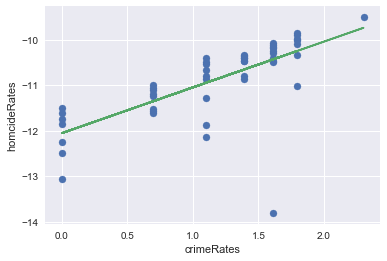

Intercept      1.222395e-47
crimeRateDF    1.823160e-08
dtype: float64
The y variable is significantly different from a null-hypthesis:  True


In [27]:
# model homicide rates as a linear function of crimerate

y, X = dmatrices('homicideRates ~ crimeRateDF', data=logcumDF, return_type = 'dataframe')

# describe model
mod=sm.OLS(y, X)
# fit model
res = mod.fit()
# look at results
print(res.summary())
yhat = np.dot(X.values, res.params.values)
fig, ax = plt.subplots()
ax.scatter(logcumDF.crimeRateDF, logcumDF.homicideRates)
ax.plot(logcumDF.crimeRateDF, yhat, color='C1')
ax.set_xlabel('crimeRates')
ax.set_ylabel('homcideRates')
plt.show()
print(res.pvalues)

pval = check_p_val(res.pvalues,0.01)
print('The y variable is significantly different from a null-hypthesis: ',pval)

                            OLS Regression Results                            
Dep. Variable:            crimeRateDF   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     45.47
Date:                Thu, 22 Mar 2018   Prob (F-statistic):           1.82e-08
Time:                        23:15:58   Log-Likelihood:                -28.353
No. Observations:                  50   AIC:                             60.71
Df Residuals:                      48   BIC:                             64.53
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.4245      0.785      8.187

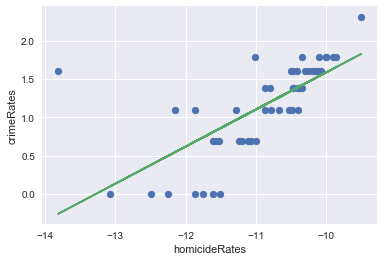

Intercept        1.152284e-10
homicideRates    1.823160e-08
dtype: float64
The y variable is significantly different from a null-hypthesis:  True


In [28]:
# modeling crimerate as a linear function of homicide rates

y, X = dmatrices('crimeRateDF ~ homicideRates', data=logcumDF, return_type = 'dataframe')
# print(y.head())
# print(X.head())
# describe model
mod=sm.OLS(y, X)
# fit model
res = mod.fit()
# look at results
print(res.summary())
yhat = np.dot(X.values, res.params.values)
fig, ax = plt.subplots()
ax.scatter(logcumDF.homicideRates, logcumDF.crimeRateDF)
ax.plot(logcumDF.homicideRates, yhat, color='C1')
ax.set_xlabel('homicideRates')
ax.set_ylabel('crimeRates')
plt.show()
print(res.pvalues)
pval = check_p_val(res.pvalues,0.01)
print('The y variable is significantly different from a null-hypthesis: ',pval)

In [29]:
corr = pearsonr(logcumDF.backgroundChecks, logcumDF.homicideRates)[0]
print('The correlation coefficient for background checks and homicide rates is %f.' % corr)

corr2 = pearsonr(logcumDF.backgroundChecks, logcumDF.crimeRateDF)[0]
print('The correlation coefficient for background checks and crime rate is %f.' % corr2)

corr3 = pearsonr(logcumDF.homicideRates, logcumDF.crimeRateDF)[0]
print('The correlation coefficient for homicide rates and crime rates is %f.' % corr3)

The correlation coefficient for background checks and homicide rates is 0.352668.
The correlation coefficient for background checks and crime rate is 0.334365.
The correlation coefficient for homicide rates and crime rates is 0.697458.


In [30]:
# scaling homicide rate over crime rate for portion of homicide by firearm of homicide

cumDF['scale'] = np.divide(cumDF['homicideRates'],cumDF['crimeRateDF'])
cumDF.head()

homicideRates  backgroundChecks  crimeRateDF     scale
State                                                             
Alabama          0.000016          508242.0          6.0  0.000003
Alaska           0.000020           90305.0          4.0  0.000005
Arizona          0.000028          330190.0          5.0  0.000006
Arkansas         0.000038          248889.0          5.0  0.000008
California       0.000030         1219907.0          4.0  0.000008

In [31]:
logcumDF['scale'] = cumDF['scale'].apply(np.log)
logcumDF.head()

homicideRates  backgroundChecks  crimeRateDF      scale
State                                                              
Alabama        -11.013261         13.138713     1.791759 -12.805021
Alaska         -10.803255         11.410948     1.386294 -12.189549
Arizona        -10.498571         12.707424     1.609438 -12.108009
Arkansas       -10.188214         12.424762     1.609438 -11.797652
California     -10.399732         14.014285     1.386294 -11.786027

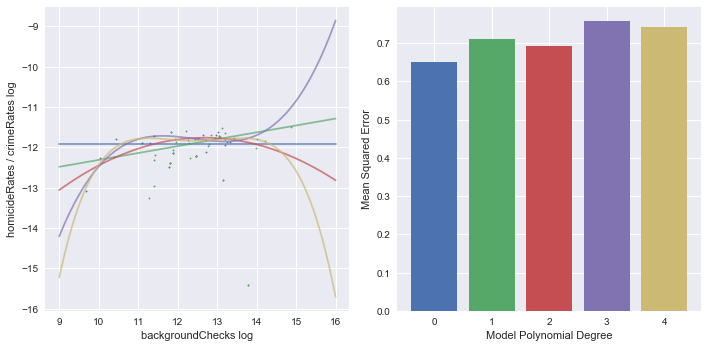

In [32]:
# modeling and testing for best line of fit for polynomials of degree 0 to 4
# by comparing mean squared error

x = logcumDF.backgroundChecks
y = logcumDF.scale

SEED = 10

np.random.seed(SEED)

test_inds = np.random.randint(0,len(x),50) # generate 100 indices randomly to be the test set
train_inds = np.setdiff1d(np.arange(len(x)), test_inds) # take the rest to be training set indices

# grabbing the training and testing data
x_train = x[train_inds]
y_train = y[train_inds]
x_test = x[test_inds]
y_test = y[test_inds]
x_plot = np.arange(9,16,0.01)
max_deg = 5
MSEs = np.zeros(max_deg)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(x_train,y_train,2,alpha=1)
plt.scatter(x_test,y_test,2,alpha=1)
plt.xlabel('backgroundChecks log')
plt.ylabel('homicideRates / crimeRates log')
for degree in range(0,max_deg):
    p = np.polyfit(x_train, y_train, deg=degree) # perform the regression on training data
    y_pred = poly_predict(x_test,p) # get the predicted value for test data

    MSEs[degree] = np.mean((y_pred-y_test)**2)
    
    plt.plot(x_plot, poly_predict(x_plot,p), '-', alpha=0.7) # this plots the regression line
    #plt.show()
plt.subplot(1,2,2)

# plot the errors and compare to each other
plt.bar(np.arange(max_deg),MSEs, color= plt.rcParams['axes.prop_cycle'].by_key()['color'][:max_deg])
plt.xlabel('Model Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.tight_layout()
plt.show()

As apparent from the test above, scaling the homicide rate by dividing over crime rate gives a batter performance for each model. However, 0 degrees of freedom is still the "best fit" to the data.

                            OLS Regression Results                            
Dep. Variable:                  scale   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.401
Date:                Thu, 22 Mar 2018   Prob (F-statistic):              0.242
Time:                        23:16:04   Log-Likelihood:                -45.912
No. Observations:                  50   AIC:                             95.82
Df Residuals:                      48   BIC:                             99.65
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -13.2509      1.018  

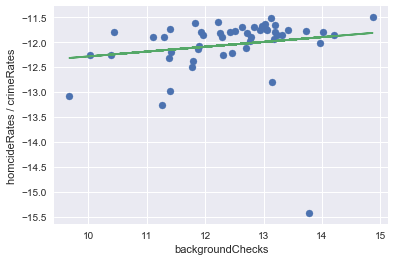

Intercept           2.312211e-17
backgroundChecks    2.424046e-01
dtype: float64
The y variable is significantly different from a null-hypthesis:  False


In [33]:
# linear modeling of (homicide rate / crime rate) as a function of backgroundchecks

y, X = dmatrices('scale ~ backgroundChecks', data=logcumDF, return_type = 'dataframe')

# describe model
mod=sm.OLS(y, X)
# fit model
res = mod.fit()
# look at results
print(res.summary())
yhat = np.dot(X.values, res.params.values)
fig, ax = plt.subplots()
ax.scatter(logcumDF.backgroundChecks, logcumDF.scale)
ax.plot(logcumDF.backgroundChecks, yhat, color='C1')
ax.set_xlabel('backgroundChecks')
ax.set_ylabel('homcideRates / crimeRates')
plt.show()
print(res.pvalues)
pval = check_p_val(res.pvalues,0.01)
print('The y variable is significantly different from a null-hypthesis: ',pval)

When scaling homicide rate by crime rate, we achieve a far better R2 value than when using raw homicide rate. However, the p-value >> 0.05 tells us that homicide/crime is not a function of background checks, so our assumption that background checks were a faithful reflection of the number of weapons sold may not be valid.

In [34]:
logcumDF2 = cumDF2.apply(np.log)
logcumDF2

homicideRates  backgroundChecks  crimeRateDF      scale
Year                                                         
2000     -10.409001         12.034274     1.535145 -11.944147
2001     -10.392996         12.079654     1.545859 -11.938855
2002     -10.330612         12.026775     1.537727 -11.868340
2003     -10.311055         12.030998     1.559827 -11.870883
2004     -10.353297         12.051957     1.539873 -11.893171
2005     -10.282775         12.084763     1.558145 -11.840920
2006     -10.284749         12.204347     1.606233 -11.890982
2007     -10.303696         12.315106     1.609438 -11.913133
2008     -10.374469         12.443848     1.561088 -11.935556
2009     -10.431785         12.540709     1.479785 -11.911569
2010     -10.484437         12.564441     1.414882 -11.899319
2011     -10.496102         12.696065     1.448330 -11.944432
2012     -10.466482         12.871155     1.442202 -11.908684
2013     -10.538991         12.945472     1.406097 -11.945088
2014     -10.586322         12.940375     1.402660 -11.988981

Now we will apply the linear regression model again on the homicide and crime rate data sets, as a function of background checks

                            OLS Regression Results                            
Dep. Variable:                  scale   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     7.199
Date:                Thu, 22 Mar 2018   Prob (F-statistic):             0.0188
Time:                        23:16:09   Log-Likelihood:                 31.676
No. Observations:                  15   AIC:                            -59.35
Df Residuals:                      13   BIC:                            -57.94
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -11.1165      0.297  

F:\anaconda\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


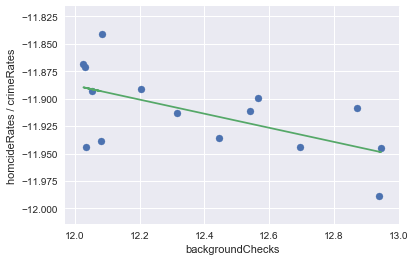

Intercept           1.258463e-14
backgroundChecks    1.878882e-02
dtype: float64
The y variable is significantly different from a null-hypthesis:  False


In [35]:
# linear regression model for (homicide rate/crime rate) as a function of background checks

y, X = dmatrices('scale ~ backgroundChecks', data=logcumDF2, return_type = 'dataframe')

# describe model
mod=sm.OLS(y, X)
# fit model
res = mod.fit()
# look at results
print(res.summary())
yhat = np.dot(X.values, res.params.values)
fig, ax = plt.subplots()
ax.scatter(logcumDF2.backgroundChecks, logcumDF2.scale)
ax.plot(logcumDF2.backgroundChecks, yhat, color='C1')
ax.set_xlabel('backgroundChecks')
ax.set_ylabel('homcideRates / crimeRates')
plt.show()
print(res.pvalues)
pval = check_p_val(res.pvalues,0.01)
print('The y variable is significantly different from a null-hypthesis: ',pval)

                            OLS Regression Results                            
Dep. Variable:                  scale   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     3.448
Date:                Thu, 22 Mar 2018   Prob (F-statistic):             0.0656
Time:                        23:16:10   Log-Likelihood:                 31.776
No. Observations:                  15   AIC:                            -57.55
Df Residuals:                      12   BIC:                            -55.43
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -17.5267     15.985  

F:\anaconda\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


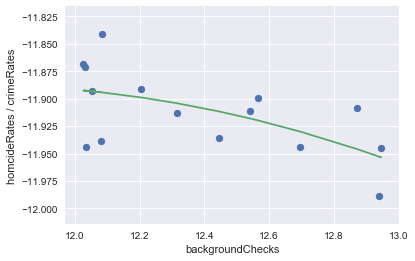

Intercept           0.294398
backgroundChecks    0.713462
bg2                 0.695408
dtype: float64
The y variable is significantly different from a null-hypthesis:  False


In [36]:
# adding dimensions for a better line of fit

logcumDF2['bg2'] = logcumDF2.backgroundChecks ** 2
model = smf.ols(formula = 'scale ~ backgroundChecks + bg2', data=logcumDF2).fit()

y, X = dmatrices('scale ~ backgroundChecks + bg2', data=logcumDF2, return_type = 'dataframe')
# print(y.head())
# print(X.head())
# describe model
mod=sm.OLS(y, X)
# fit model
res = mod.fit()
# look at results
print(res.summary())
yhat = np.dot(X.values, res.params.values)
fig, ax = plt.subplots()
ax.scatter(logcumDF2.backgroundChecks, logcumDF2.scale)
ax.plot(logcumDF2.backgroundChecks, yhat, color='C1')
ax.set_xlabel('backgroundChecks')
ax.set_ylabel('homcideRates / crimeRates')
plt.show()
print(res.pvalues)
pval = check_p_val(res.pvalues,0.01)
print('The y variable is significantly different from a null-hypthesis: ',pval)

                            OLS Regression Results                            
Dep. Variable:                  scale   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     1.692
Date:                Thu, 22 Mar 2018   Prob (F-statistic):              0.228
Time:                        23:16:11   Log-Likelihood:                 32.248
No. Observations:                  15   AIC:                            -54.50
Df Residuals:                      10   BIC:                            -50.96
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -4.274e+04   6.08e+04  

F:\anaconda\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


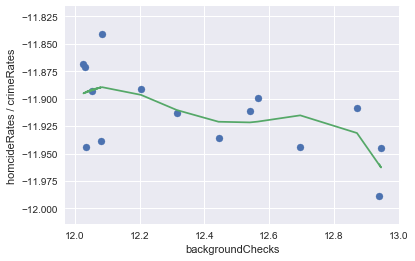

Intercept           0.498334
backgroundChecks    0.497409
bg2                 0.496372
bg3                 0.495338
bg4                 0.494306
dtype: float64
The y variable is significantly different from a null-hypthesis:  False


In [37]:
# adding yet more dimensions
# where the result is an overfitted model over 15 datapoints (one for each year) 
# that will not be able to do anything for a different dataset (variance) but fits the data at hand quite well
 
logcumDF2['bg3'] = logcumDF2.backgroundChecks ** 3
logcumDF2['bg4'] = logcumDF2.backgroundChecks ** 4

model = smf.ols(formula = 'scale ~ backgroundChecks + bg2 + bg3 + bg4', data=logcumDF2).fit()

y, X = dmatrices('scale ~ backgroundChecks + bg2 + bg3 + bg4', data=logcumDF2, return_type = 'dataframe')
# print(y.head())
# print(X.head())
# describe model
mod=sm.OLS(y, X)
# fit model
res = mod.fit()
# look at results
print(res.summary())
yhat = np.dot(X.values, res.params.values)
fig, ax = plt.subplots()
ax.scatter(logcumDF2.backgroundChecks, logcumDF2.scale)
ax.plot(logcumDF2.backgroundChecks, yhat, color='C1')
ax.set_xlabel('backgroundChecks')
ax.set_ylabel('homcideRates / crimeRates')
plt.show()
print(res.pvalues)
pval = check_p_val(res.pvalues,0.01)
print('The y variable is significantly different from a null-hypthesis: ',pval)

# Discussion


In this analysis we drew on state firearm background check data, homicide rates and historical population estimates
from RAND State Statistics in addition to a dataset from the FBI’s Uniform Crime Reporting database to probe the
relationship between state gun-related crime rates with the frequency of background checks conducted on potential
weapons buyers. We limited our analyses to include only those years represented by all four datasets, namely the
period from 2000 to 2014. We corrected for missing data via linear regression from preceding years’ data for the
state in question.

Advocates of gun control argue that legislation to disrupt the sale of firearms to ineligible individuals will
reduce the number of firearm related deaths. If we had found a correlation between the frequency of background checks
in a given state and that state’s firearm homicide rate, as we have hypothesized, we could have concluded that
stricter gun control legislation is a viable way to alleviate gun violence in the United States. We were unable to find
a reliable correlation between background check rates and incidence of gun violence. Even if we had found one, as we 
have only correlated these data sets, causation could not be inferred from our current analysis; it is unclear whether
increased crime rates drive people to buy more guns, or whether areas with more gun owners have more crime. Indeed, the National
Justicse institute indicates that most violent gun offenders obtain their arms through illegal means.
(https://www.nij.gov/topics/crime/gun-violence/Pages/aquired.aspx)
Additionally, the short time frame limits the strength of the claims we can make. 14 years’ worth of data is not
enough to draw conclusions about long term gun violence trends. More longitudinal data is needed to deepen our understanding
of the factors that contribute to gun violence. We had assumed gun background checks reflected the of firearm sales.
Murder rate may reflect a number of factors, including the state of the local economy, presence and efficiency of
law enforcement, population density (densely packed areas tend to have higher crime rates), and the presence of
organized crime groups and drug trafficking.



# Privacy and Ethics


The data analyzed here were collected by the FBI and are publicly available at Rand State Statistics. FBI’s National
Instant Criminal Background Check System (NICS) collects reports on firearm sales directly from authorized sellers;
this means that any firearms sold online or privately are not counted in the dataset. It is therefore possible that
any individual purchasing a firearm with malicious intent would seek out other channels and thus not be represented in
the data, resulting in a potentially biased dataset.The datasets do not contain any information concerning any one individual,
and neither names nor dates of birth or other potential identifiers are present. 
Data from RAND State Statistics is free to use for academic research but may not be edited or reproduced for profit. 
Terms of use and privacy policy can be read in their entirety at the following link: http://www.randstatestats.org/terms

# Conclusion and avenues for future research

As we did not find a strong correlation, it would be worth considering another test with data on crimes rates carried out
without firearms. It may well be that non-firearm related crimes are are more prevalent in states performing more frequent
background checks than those with more lax laws on gun-ownership. In otherwords, perhaps those who are prevented
from commiting gun crimes simply find other means to commit violent acts. This possibly was not explore here but would be 
reveal some interesting trends. This would again be modeled using linear and/or polynomial
regression. 


